In [1]:
import pandas as pd
import random
from itertools import combinations, groupby
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from collections import Counter

In [3]:
# read csv file
df = pd.read_csv("trnsact.csv", header=None)

In [5]:
df_t = df.drop(columns=[13],axis=1) # col[13] is always zero
df_t = df_t[(df_t != 0).all(1)] # remove zero values
df_final = df_t.iloc[:,[0,1,4,5]].copy() # clean data. 0 is SKU, 1 is Store num, 4 is Transaction Code, 5 is Date
df_final = df_final.reset_index(drop=True)
df_final = df_final[df_final.groupby([1, 4, 5])[0].transform('count')  > 2] # Combine col[1,4,5] as order specifix value. we only select orders that has three or more items in it
df_final.head()

,0,1,4,5
1,5,9709,400905956,2005-06-25
3,24,404,204309919,2005-08-26
7,24,2404,785100168,2005-08-15
8,24,3102,48001485,2005-08-20
9,24,4704,381308494,2005-08-25


In [4]:
# dataset is list of orders
# return is a dataframe with orderNo as index and item_id as SKU 
def convert_orders_to_skus(dataset):
    order_counts = pd.DataFrame(columns=["orderNo","sku_id"])
    for index, l in enumerate(dataset):
        if index % 1000 == 0:
            print(index, l)
        index_list = [index] * len(l)
        result = zip(index_list, l)
        tmp_df = pd.DataFrame(list(result),columns=["orderNo","sku_id"])#
        order_counts = order_counts.append(tmp_df)
    order_counts = order_counts.set_index('orderNo')
    return order_counts;

def get_count(iterable):
    if type(iterable) == pd.core.series.Series:
        return iterable.value_counts().rename("count")
    else: 
        return pd.Series(Counter(iterable)).rename("count")

# Since dataset is relatively large, using generator could increase performance 
def get_sku_pairs(dataset):
    dataset = dataset.reset_index().as_matrix()
    for order_id, sku in groupby(dataset, lambda x: x[0]):
        sku_list = [item[1] for item in sku]
              
        for sku_pair in combinations(sku_list, 2):
            yield sku_pair
            
# eliminate dataset by support value
def limit_by_support(dataset, min_support):
    print("Processing order_item with size: {:d}".format(len(dataset)))
    # Calculate each SKU item frequency
    status = get_count(dataset).to_frame("count")
    # Calculate support for each SKU item
    status['support'] = status['count'] / len(set(dataset.index))

    # remove rows from dataset that has support less than threshhold
    qualifying_orders = status[status['support'] >= min_support].index
    dataset = dataset[dataset.isin(qualifying_orders)]

    # Recalculate item frequency and support
    status = dataset.value_counts().rename("count").to_frame("count")
    status['support'] = status['count'] / len(set(dataset.index))
    
    sku_pair_gen = get_sku_pairs(dataset)
    
    # Calculate item pair frequency and support
    result = get_count(sku_pair_gen).to_frame("countAB")
    result['supportAB'] = result['countAB'] / len(set(dataset.index))
    print("SKU pairs: {:d}".format(len(result)))
    result = result[result['supportAB'] >= min_support]
    return status, result

In [38]:
# This process took about an hour. please refer to the file "dataset"
orderMap = dict() # rearrage data, put into a list of orders with key as order informations
for index, row in df_final.iterrows():
    key = str(row[1]) + "," + str(row[4]) + "," + row[5]
    if index % 1000 == 0:
        print(key)
    if (key) in orderMap:
        orderMap[key].append(row[0])
    else:
        orderMap[key] = [row[0]]

4004,776701276,2005-03-26
7407,115706920,2004-09-04
8603,906005891,2004-08-11
2602,698705842,2004-08-04
3204,178800558,2005-01-18
1607,507308937,2005-05-04
4207,460102269,2005-01-05
1204,461300176,2005-07-02
3307,98408916,2005-07-29
1609,50303181,2005-05-28
5704,877405959,2005-08-19
3807,446406840,2005-07-15
5402,816308726,2005-07-07
2007,870002670,2005-06-23
5604,15605855,2005-08-09
3207,845300886,2005-01-11
4407,492706247,2005-03-25
1407,798002785,2004-08-07
4907,315800817,2005-04-12
9103,884109907,2005-07-18
8002,683307934,2004-10-03
2103,277101323,2005-06-23
107,769808426,2005-02-26
9806,522908747,2005-01-22
8109,146809056,2005-01-07
8902,576700214,2004-12-08
9503,753108223,2004-09-11
3409,772406249,2004-11-26
8404,168206441,2004-09-02
5802,198606983,2005-01-01
5203,978905924,2004-12-04
3909,815605929,2005-02-23
4007,57502760,2004-12-07
2004,73309335,2005-05-16
1202,5504339,2004-12-05
2607,337203045,2005-05-25
4307,275106183,2005-06-20
3409,500005771,2005-04-08
8109,459506595,2005-

9002,514508972,2005-02-13
1104,260102183,2005-07-16
2609,378301152,2005-08-13
1407,742800831,2005-04-15
7502,308005860,2005-01-12
709,299101211,2004-12-17
4102,74805865,2005-01-27
1104,561408553,2005-07-27
1607,748101159,2005-07-02
3702,187804086,2005-08-14
9404,38609899,2005-07-30
3304,603802886,2005-05-14
209,675702024,2005-02-04
3709,989405930,2005-07-18
9104,976200666,2004-09-02
5503,337605895,2004-09-09
8703,668806471,2004-10-07
2203,54508934,2004-10-02
1203,913202791,2004-11-13
2503,328900375,2005-04-02
3202,639403914,2005-01-29
709,834103133,2005-04-15
2504,368600156,2005-02-14
4309,282908556,2005-03-21
7907,83800984,2005-01-18
1602,530204093,2005-02-16
9503,699805926,2005-02-09
2109,634808219,2005-04-19
8709,121408380,2005-02-15
1109,111308167,2005-02-24
403,933500305,2004-12-16
3909,954705791,2005-07-11
3502,452708824,2005-02-23
2204,152307351,2005-03-30
2702,144404117,2005-03-20
2009,489809139,2005-03-30
1307,902504427,2004-09-10
2907,59103119,2004-09-08
1302,237800130,2005-0

6902,357906314,2004-10-01
7702,881608844,2005-04-21
7907,998304654,2005-08-15
9103,679207387,2005-07-28
7604,584306529,2005-08-03
6903,374808069,2005-08-22
6102,751308046,2005-08-06
6002,257509914,2005-07-30
2207,94004365,2005-08-09
1003,230201335,2004-10-12
2503,368008686,2004-11-04
8404,832500695,2004-09-14
4302,708305831,2005-01-15
7502,315708128,2004-12-29
8604,355608073,2004-09-02
3807,285908843,2004-09-08
5302,392803921,2004-10-16
9303,901903182,2004-10-11
4704,299703387,2005-03-01
6803,289305638,2004-12-14
4202,53303059,2005-03-04
1707,809909919,2005-07-05
9804,549201954,2005-07-08
8803,690509628,2005-06-24
4803,876008667,2005-08-15
9402,932209037,2005-03-24
2203,673208920,2005-05-13
7907,68204734,2005-08-19
4302,287608269,2004-12-12
8109,159405951,2005-02-13
7107,572802428,2005-07-06
903,73104846,2005-04-15
604,445202526,2005-08-19
4503,420600486,2004-09-21
2202,201108642,2005-06-28
1203,295104200,2005-02-23
2602,326201320,2004-08-25
4004,455900034,2005-03-12
7103,352200275,200

1009,549702889,2005-02-19
7407,356605429,2004-09-11
1607,472608910,2005-02-21
409,253709109,2004-12-26
5304,20705874,2005-04-08
4607,527001653,2005-08-04
4507,562700900,2005-02-25
4209,352103095,2005-04-16
3204,109805647,2005-07-29
304,40501643,2005-06-11
2202,236909142,2005-07-15
1109,627209790,2005-08-12
8602,181600505,2005-07-14
8803,691908544,2005-07-26
4907,403200812,2005-06-14
4307,295602252,2005-03-19
9909,587606861,2005-06-07
4107,8308764,2004-09-29
5202,977505501,2004-09-11
1307,89001252,2005-02-21
7004,138106394,2004-12-04
4607,955009025,2004-11-26
7403,179100282,2004-12-18
9309,75402839,2004-09-09
2607,721101017,2005-02-05
2409,927306320,2004-09-02
3702,735005061,2004-12-13
3502,925704575,2005-06-19
4207,368408818,2005-08-18
707,153208609,2004-09-29
9404,663400642,2005-02-15
1202,395700132,2005-07-10
1904,950801793,2005-07-02
6102,410806723,2005-02-15
504,22800570,2005-06-04
4007,201651,2005-05-07
2109,961308152,2005-08-26
8209,986909952,2005-08-08
3102,786207538,2004-11-06


8604,664301738,2005-04-29
1007,760709343,2005-07-15
204,455708420,2005-02-26
2504,666204077,2005-07-31
7303,509800287,2004-12-16
8602,690307323,2005-08-02
1107,102875,2005-02-23
7507,362304359,2004-08-25
8007,393008939,2004-09-03
8803,567407079,2005-03-08
302,201500114,2004-09-03
2102,431101544,2004-11-13
9804,82800634,2004-12-04
7603,82205745,2005-02-19
2409,233201150,2004-12-17
7202,966708928,2004-10-02
5803,991207162,2004-09-29
7303,375409338,2005-05-07
2707,995701068,2005-02-25
6703,781503123,2005-01-01
8309,276706921,2004-10-02
407,831009344,2005-07-26
7202,788805858,2005-06-22
4409,695408349,2004-08-22
8102,749608378,2005-04-14
8407,418806186,2005-03-04
5602,299509906,2005-07-05
1709,626201222,2005-07-22
3809,801908535,2005-06-24
9103,133205882,2005-03-07
3202,424708162,2004-08-20
3009,718007178,2004-11-10
2309,373401243,2005-07-28
5503,199808899,2005-02-11
3009,611108918,2005-01-05
5203,29508901,2005-04-14
9603,524604229,2005-02-25
1304,156300615,2004-12-26
7302,980007251,2004-1

2007,415208231,2005-08-25
4704,566405987,2005-05-25
1307,216403106,2005-06-14
603,41901459,2005-07-30
2307,868009191,2005-06-23
4807,290900546,2005-06-01
9609,328105245,2005-02-02
3204,349407003,2004-10-30
1509,585408713,2004-10-14
7502,287508059,2004-09-20
9204,731501593,2005-03-12
6204,430408886,2004-12-26
2404,445100161,2004-09-06
3003,746307398,2005-04-21
4503,691200485,2005-08-02
5204,267100029,2004-08-08
8404,801702231,2004-09-25
7002,814505735,2004-11-09
3503,251000429,2004-09-05
1909,895209120,2004-11-12
2807,609401078,2005-02-24
8703,913405892,2005-07-27
8407,538108621,2005-01-16
4707,551501148,2004-12-01
8702,212708412,2005-06-02
4202,438204190,2005-03-22
8504,354001844,2005-05-02
807,404000749,2005-07-02
3204,319900553,2005-06-24
5704,922609014,2005-07-26
8902,203906398,2005-03-07
3604,289204201,2005-08-18
909,706505108,2004-11-27
2807,991901473,2004-12-04
9806,408905803,2004-12-15
1407,629808857,2005-04-24
2303,191101896,2005-06-06
3207,859806467,2005-08-05
5604,111408895,2

2007,401501042,2004-11-16
3303,453600439,2004-09-11
4403,673600482,2004-11-29
6102,232308702,2005-02-17
7804,109108443,2005-02-26
9604,855202353,2004-12-02
9304,703400656,2005-05-26
1709,642008542,2004-11-12
6604,632700057,2004-08-20
5302,244808760,2004-10-29
6102,791505576,2004-12-11
7307,450608800,2005-07-05
4307,839501128,2005-02-16
4102,475804111,2005-04-01
307,707001847,2005-03-30
2509,672808254,2004-12-23
3202,22207192,2004-12-02
4307,567801123,2005-07-25
4704,356101465,2004-10-31
6804,11502149,2004-09-23
9304,182300635,2005-07-02
2609,662908172,2005-01-30
407,99208074,2004-10-16
4502,522403262,2005-02-06
7602,97505799,2005-03-26
4507,188007416,2005-04-24
404,683403348,2005-08-16
2109,728409027,2005-08-24
4907,638600815,2005-07-28
9304,139903279,2005-06-27
4402,652506607,2005-03-02
3909,294208373,2005-07-06
202,389506603,2005-07-23
1403,743901573,2005-07-27
7307,399801966,2004-09-30
1104,407301790,2004-11-24
9002,348700506,2004-08-17
3102,103900075,2004-12-23
7402,457308269,2005-

7507,156908655,2004-12-31
8102,348706866,2005-04-09
7503,269102372,2004-10-12
3604,708609066,2005-02-25
1103,685400392,2005-04-10
107,25108912,2005-07-02
3304,937708972,2005-03-16
2207,466902671,2005-07-01
7202,753106888,2005-07-19
3409,381009778,2005-04-08
9204,637602019,2005-04-17
2303,161401216,2004-10-08
4803,232109004,2004-09-05
8402,363803083,2005-07-22
3604,738404502,2005-05-07
2609,204901153,2005-07-09
3007,625200895,2004-08-28
8202,742505811,2005-08-03
7507,150200905,2004-08-04
3003,816602215,2005-01-30
6803,16801699,2005-02-23
2503,242502407,2005-02-26
3409,342405689,2004-10-27
5303,871005916,2005-01-30
1904,25008658,2005-03-18
6009,875305277,2004-11-13
407,898908212,2005-01-15
6604,669404426,2004-09-11
5904,759306818,2005-02-21
2203,331601336,2005-04-06
807,879400754,2005-07-30
6009,441405294,2005-08-27
2203,632402625,2004-12-14
1302,486109048,2005-05-08
9209,577507274,2005-07-22
1404,741308351,2004-09-30
6304,510308886,2004-11-24
509,965709267,2005-08-14
4109,408101267,2005

2203,596304760,2004-12-09
7303,893605083,2004-08-26
2509,469509194,2005-02-23
8507,244309346,2005-02-21
9204,210109102,2004-11-30
7904,660705598,2004-12-10
8703,440806064,2005-07-13
5304,891409227,2005-03-03
7603,382905906,2004-12-14
5302,710109122,2004-11-07
8607,72405482,2005-02-23
3302,604009804,2005-08-26
2502,483405364,2005-06-08
403,77101734,2005-06-30
3109,386905548,2005-07-11
3307,48608154,2005-06-25
3204,665800552,2004-11-10
504,25605653,2005-07-29
2207,219807725,2004-08-21
4507,120900901,2004-08-26
507,204400872,2005-07-12
2307,328801049,2005-08-27
3409,686109240,2005-01-26
7407,350905036,2004-10-03
3602,247800102,2004-10-03
7302,979808967,2005-05-20
2509,522803352,2004-10-02
409,37108943,2005-04-12
3603,909800459,2005-05-16
3302,513400065,2004-12-05
8403,466905238,2004-12-18
8402,9208781,2005-02-24
4102,534701545,2004-12-09
4707,387707849,2004-12-17
5103,155008069,2005-06-23
1707,537200783,2005-01-29
7204,29205576,2005-07-24
1109,407407045,2005-05-25
3207,727506776,2005-06-0

1807,198903365,2005-06-11
2707,703104195,2005-01-26
6102,750008332,2005-08-26
107,318809107,2004-11-21
2604,703809033,2005-05-07
8204,922600686,2005-04-11
1004,652008801,2005-07-11
7402,265208883,2004-08-03
9806,351508319,2005-07-12
6203,142508582,2005-07-14
4702,258607457,2005-08-27
4303,872001579,2004-12-16
3302,576307541,2004-10-26
1707,781500783,2005-07-16
7403,919909805,2005-05-23
3807,387101064,2004-09-30
7403,309606912,2004-12-08
3102,591601529,2004-11-23
2804,219708930,2005-03-21
107,838008786,2005-01-28
7403,302000283,2005-01-08
7102,820907906,2005-08-13
704,435307564,2004-08-12
9806,720201823,2005-02-01
4102,866707240,2004-09-25
4004,486505993,2004-11-09
1107,114108126,2004-10-02
7104,804405784,2005-01-17
1002,978109894,2005-05-19
3109,411308309,2005-07-24
7004,323209013,2005-05-15
5804,842807268,2005-05-21
8709,977008484,2005-08-20
8102,14402731,2005-03-15
8707,245800993,2005-08-17
107,956107324,2005-07-30
6203,207108719,2004-12-08
3102,125508041,2004-09-21
3302,477506370,20

7707,106008847,2004-08-25
6503,476507322,2005-02-28
8402,833207741,2004-09-26
103,114400335,2004-10-02
7002,548007987,2004-11-28
2303,733808721,2004-12-29
4202,257501449,2005-03-05
709,217805379,2005-03-08
4607,630604554,2005-01-26
7507,7306952,2005-06-08
2102,666005222,2005-06-21
3602,352708869,2005-08-05
4104,673402300,2005-04-07
1502,833303183,2005-07-18
9804,569003087,2005-07-01
5704,857407905,2005-05-29
807,134006332,2005-08-13
2307,94909856,2005-08-14
8404,253508183,2004-10-19
7307,439700985,2004-09-29
2504,639900167,2005-01-29
7202,524605857,2004-12-04
1202,785107585,2005-08-22
4409,986205360,2004-12-03
103,788808357,2005-02-24
6503,847000267,2004-12-13
7707,503406184,2005-02-27
4407,648404661,2005-03-11
8202,730407272,2005-06-03
7702,14508676,2005-04-05
8709,492709010,2005-02-25
3609,123708095,2004-10-18
8007,618901296,2004-11-14
1107,821406659,2005-05-30
4707,548008692,2005-07-08
8402,698402570,2005-07-29
5403,969105907,2005-06-30
3102,313008345,2005-08-26
9504,155508271,2004-

4109,900908927,2005-01-13
3007,430109041,2005-03-24
3603,279002348,2004-12-02
3409,302306748,2005-02-21
3307,973601102,2005-06-08
1107,218209315,2005-05-16
6202,639809872,2005-08-13
102,856802015,2005-03-18
6403,92003110,2005-02-22
8109,82802777,2005-08-06
9402,520908465,2005-08-27
2607,230208683,2005-07-22
3307,461808516,2004-09-26
1407,695500845,2004-09-01
4403,929806538,2004-08-04
8802,608104420,2004-09-10
9404,923708043,2004-08-30
9103,233205899,2005-03-04
4707,676408190,2004-08-01
8402,717002156,2004-11-08
4504,623000006,2004-10-23
5903,271406770,2005-02-25
8602,315602916,2004-10-01
7007,57009283,2005-02-28
7703,936108694,2005-05-17
4204,256909045,2005-08-20
9609,63504700,2005-04-21
7407,872508958,2005-07-27
7502,940508027,2005-08-06
2209,156402284,2005-03-15
8209,31801657,2005-06-01
3007,88806368,2004-11-27
9806,586309090,2005-02-14
3604,721907194,2004-11-04
7707,711207238,2005-01-23
3109,394102912,2005-03-16
7702,180501767,2004-12-02
1502,741909032,2004-11-28
7004,646109130,2005

4307,49200904,2004-11-11
8209,675302821,2004-11-16
4303,967605212,2005-02-13
707,816608318,2005-07-02
6604,382008490,2005-03-05
7102,919308557,2005-07-17
8602,855900492,2005-04-19
4102,518104367,2005-04-25
709,278304492,2005-04-02
8703,686707115,2005-06-30
3109,277509932,2005-06-06
7407,730804307,2005-02-24
1407,768900832,2005-03-26
6009,595405294,2005-06-09
209,634201167,2004-11-30
4802,271608889,2004-08-28
4004,822509013,2005-03-25
2509,229602014,2004-08-07
3309,123002325,2005-01-12
9204,759808913,2005-05-30
7707,14403309,2004-08-20
2009,304209285,2005-06-22
4902,160408794,2005-03-07
8409,648309266,2005-05-05
5004,16407344,2004-08-21
309,339401218,2005-06-05
6503,7800250,2004-09-17
7502,254508187,2004-10-13
2309,611308920,2005-02-06
2103,381202118,2005-01-03
3804,731508670,2005-01-26
504,890207195,2005-02-23
1104,337807393,2005-07-24
2203,400409208,2005-01-26
2809,392405045,2005-04-11
7507,103704261,2005-03-06
2004,898505872,2004-12-17
6902,823609815,2005-08-08
407,658208659,2005-01-

1703,371900386,2005-05-14
6102,456209366,2005-03-19
1904,360604534,2005-08-25
209,86404268,2005-06-10
3102,697001397,2004-12-23
4202,91006845,2005-08-22
4607,823008940,2005-02-20
3502,370309122,2005-06-24
3304,849601835,2005-08-05
3304,468108846,2005-03-19
3007,459804172,2004-09-25
3002,999109837,2005-08-26
8604,288701268,2005-02-19
2707,826408546,2005-05-07
2303,470707067,2005-07-30
603,108908329,2004-08-13
504,375304163,2004-11-11
8302,731900488,2004-12-19
3407,93807424,2005-07-15
3304,931305939,2004-11-09
2303,206306998,2004-09-14
5704,27208041,2004-10-27
6102,751308924,2005-03-26
3407,239007424,2005-08-24
7507,888300960,2005-02-23
6803,643608409,2005-02-23
4104,289500018,2005-01-22
6104,290808065,2004-10-31
2804,949402212,2004-12-17
5203,322409656,2005-08-07
203,625310020,2005-08-17
4403,438707034,2005-06-16
1203,535804382,2004-12-22
5503,737005896,2005-01-07
302,191202007,2005-07-24
4402,342108999,2005-07-07
9303,822305883,2005-07-25
209,581908942,2005-06-29
3207,857205350,2005-06

7004,483306728,2005-02-18
2504,718004077,2005-03-11
5903,877806572,2004-12-17
8204,856302526,2005-02-04
5904,802805723,2005-07-17
5104,12708614,2005-05-27
2109,440103134,2005-08-13
3103,103001943,2005-03-09
3902,851009123,2005-06-30
909,731408862,2005-08-26
507,978304157,2004-12-24
3204,362706386,2005-08-06
8607,200702243,2005-08-05
7707,448500936,2005-08-27
4409,911708643,2005-03-11
6803,200503945,2004-09-16
1707,289501403,2004-08-08
3303,140007296,2004-09-07
8707,437402361,2005-01-29
9804,325906318,2005-03-18
1607,563200960,2004-09-06
1004,717700184,2005-01-20
102,597006530,2004-09-29
6002,337207079,2005-02-12
9309,412708777,2005-01-26
7403,541200060,2005-02-22
102,24706390,2004-11-27
5803,230806077,2004-12-14
209,818901200,2005-03-03
5904,351407925,2004-12-21
502,410300137,2004-10-26
6804,444709059,2005-08-03
8002,359809126,2004-12-14
1709,441804316,2005-02-27
704,234408084,2004-11-05
8802,852605746,2004-10-29
4407,848504114,2004-10-13
1304,385701964,2005-04-20
4409,648801264,2005-0

1109,140908073,2005-07-03
4307,623806360,2005-08-24
1104,208104552,2005-05-27
6002,258107526,2004-11-17
2407,799004150,2004-08-30
2304,144108681,2004-10-01
107,551208911,2005-08-07
6203,548303042,2005-06-02
409,911309149,2004-12-18
4209,769601259,2005-08-23
5102,303308789,2004-12-16
7703,354507193,2005-02-25
3704,305901293,2004-09-24
1609,105901234,2005-03-04
9302,186807151,2004-09-27
107,757002281,2005-02-16
8404,578907767,2005-06-11
3607,468201473,2005-03-14
5204,666000029,2005-03-30
9303,83607632,2005-03-29
3102,627701397,2005-08-05
402,576808576,2004-08-09
1003,964206996,2005-07-16
1007,568708424,2005-05-09
809,713701174,2004-08-28
3704,772700802,2004-08-30
2203,847608971,2004-10-16
3709,406509858,2005-07-03
6304,754702800,2005-07-16
8703,529505558,2004-09-24
6002,988206863,2004-09-15
3407,521505430,2004-10-07
7603,326709050,2005-01-08
6002,976906863,2005-01-30
4209,274601267,2005-01-25
6203,820100241,2005-07-21
2004,709304768,2004-09-30
3807,815001016,2005-02-20
7407,407904450,200

1607,708402652,2005-08-27
409,92708861,2005-02-14
504,699908855,2005-05-25
5002,408305456,2005-03-08
4802,52904541,2005-07-21
2707,794301067,2005-08-25
5103,647005920,2005-06-23
303,210300338,2005-01-30
3204,479701835,2005-01-15
8709,106805955,2004-10-21
6204,306508886,2004-12-08
9503,835000294,2004-09-30
6009,266606335,2004-10-02
3009,939208640,2005-02-26
9309,405506534,2004-09-01
3109,747302864,2004-12-20
3409,651005974,2004-09-16
1207,762900751,2004-09-27
4404,659708298,2005-01-13
9104,927000666,2005-02-05
3407,912207842,2004-11-06
2603,301809005,2005-03-17
3303,981502312,2004-12-11
4707,695604149,2005-01-12
6503,705702756,2005-08-19
8902,17802774,2005-05-14
2307,743201755,2005-01-02
4702,218606451,2005-06-03
6009,727105246,2004-12-24
8802,70607002,2005-08-27
3909,400706538,2005-04-10
2704,778009311,2005-05-10
304,608100611,2005-07-06
807,520507807,2004-10-01
4502,225409367,2005-03-18
3607,131702548,2004-09-25
3307,458008579,2004-12-18
3109,888508166,2005-02-25
2607,229609025,2005-0

8109,668604531,2005-07-17
3502,189404474,2005-08-21
1404,834906851,2005-05-28
1807,63203141,2005-07-26
6804,287409892,2005-06-18
7503,881505439,2004-10-02
1607,223103997,2004-08-25
3607,62405480,2005-01-16
102,341005347,2004-12-29
3902,465503316,2005-05-15
3204,145004140,2004-09-24
407,281408075,2004-08-28
1704,972305976,2005-02-23
5502,278006888,2004-12-16
7603,794808899,2004-11-09
3604,744302573,2005-02-25
907,76207803,2005-01-26
7507,948308876,2005-08-25
4403,550509842,2005-05-12
3807,662108800,2005-03-08
209,587208942,2004-09-17
2502,786406571,2005-02-23
402,135200116,2004-09-29
203,704001278,2005-03-25
9204,11107765,2005-03-02
8302,226503155,2004-09-30
4502,95308676,2005-04-23
2503,905502791,2005-04-18
2207,653704658,2005-03-12
3604,997305440,2004-12-15
8102,488800527,2004-12-20
1403,95302170,2005-03-01
5402,517506819,2005-03-30
3702,181208028,2005-05-24
107,446200835,2005-08-17
3003,335308257,2004-08-03
3707,154601010,2004-12-20
6604,165303096,2005-04-15
1304,251508644,2004-08-25

4907,140104305,2005-04-24
7707,750901862,2005-03-25
8703,871408898,2005-06-05
8204,784300695,2005-02-16
6403,74607292,2004-12-19
209,507702130,2004-11-20
2504,876000173,2004-10-20
4907,708408937,2004-10-13
8402,762403967,2005-02-26
5503,896505894,2004-09-08
909,267005359,2005-03-19
4007,96801114,2004-12-23
8102,37700516,2004-12-02
407,467607468,2005-03-05
3304,982908592,2004-11-18
6102,903808849,2004-11-07
7104,779805124,2004-12-13
3807,63302283,2005-03-01
3309,446106361,2004-12-20
9304,870407137,2005-02-20
1203,960708549,2005-06-26
9103,288509624,2005-07-06
3007,301704399,2005-03-12
7304,819908485,2005-03-10
7507,368805634,2005-04-02
2102,553803746,2005-02-05
4207,977306909,2005-08-27
5604,922908067,2005-08-03
9209,409907978,2004-08-31
7807,624708768,2004-08-13
7303,658008519,2004-08-11
1104,220907942,2004-09-11
707,144403988,2004-10-24
2402,206202733,2005-04-01
3807,235602934,2004-12-01
9409,240203247,2004-08-12
7107,638504792,2005-07-31
504,684002288,2005-01-29
1109,782808375,2005-0

4307,63501126,2005-01-26
8803,25905728,2005-06-09
7002,945705808,2004-09-06
1204,437500186,2004-10-12
2307,737906781,2004-11-06
2004,657409167,2005-08-20
8007,635107818,2005-06-21
1002,833909382,2005-03-09
3802,40908175,2005-03-03
9804,844309022,2004-09-23
4703,710308873,2005-05-19
5403,560505917,2005-01-26
8002,480100523,2005-03-08
4404,237109121,2005-08-24
3209,961208277,2005-07-05
402,464902773,2005-02-28
7107,198001625,2005-04-30
1207,881300763,2005-02-28
2804,677003145,2005-07-27
3304,689601362,2005-06-11
3507,26708916,2004-08-03
1404,144804257,2004-10-03
103,639900352,2005-02-23
7502,287908982,2005-03-01
5803,658305910,2004-11-19
3603,599401577,2005-01-28
9103,705805882,2005-02-03
9704,894000710,2005-05-17
2203,519600425,2005-01-10
404,840408335,2004-10-01
4202,355902036,2004-08-06
3507,618804309,2004-08-17
2602,462408118,2004-11-21
7907,967209127,2005-02-12
4207,770706480,2005-03-12
1502,846000255,2005-02-10
7107,172201315,2005-06-26
2207,714407305,2005-07-30
4607,489908446,2004

3204,519300557,2005-02-25
3603,339400437,2005-02-20
2204,515805963,2005-08-03
8702,720400520,2005-02-24
707,739600747,2004-10-29
5303,296708932,2005-01-08
3103,957103229,2005-02-23
3607,763801890,2005-03-13
5803,664606439,2005-03-12
409,705008617,2005-04-04
4404,997603198,2005-07-02
8503,652308098,2005-03-24
8407,828608131,2005-06-22
7907,773508271,2005-07-15
4007,663808433,2005-03-11
6203,773509255,2005-04-27
6109,552609922,2005-07-09
107,815509344,2005-07-14
1709,785508242,2004-09-30
8602,925306931,2004-10-01
4902,325005879,2005-03-01
4707,15507334,2004-08-27
3909,447306391,2004-09-15
4902,323303115,2005-01-20
2603,762708099,2005-02-26
7907,132408669,2005-02-25
2604,897504743,2004-12-11
707,548808776,2004-09-10
2209,175404099,2005-01-01
9402,745607002,2005-01-28
2103,305109005,2005-08-25
8302,291507402,2005-03-25
8403,463102507,2005-02-02
4802,559505838,2005-04-20
4607,9607019,2005-02-04
7404,51705650,2005-08-19
6104,562705969,2005-06-23
3204,56305199,2004-09-13
203,417403956,2005-07

202,897000105,2004-11-24
3807,939009920,2005-08-15
5103,847409155,2004-12-17
8004,107803560,2005-07-16
1007,895604630,2004-12-20
704,182106884,2005-02-18
6203,959100223,2005-02-24
3807,180104662,2005-02-23
3003,548008695,2005-02-25
3502,348301529,2005-05-15
3303,346700462,2004-11-23
9806,882707926,2005-03-23
6302,510106577,2004-08-31
203,430404296,2005-06-17
3609,368307260,2005-07-31
7103,499600280,2005-02-27
8007,751408271,2005-07-02
3403,631609080,2005-02-24
2104,278909855,2005-07-16
3709,637109145,2005-02-24
4007,89104667,2005-08-02
1403,694208323,2004-12-07
7907,430604218,2005-07-31
5204,248200030,2004-09-15
709,490009109,2005-05-13
4403,465803318,2004-09-02
603,211902817,2004-10-03
603,3700312,2005-06-09
2409,325501122,2004-11-30
4207,516400878,2005-06-16
8607,191506188,2004-11-06
4603,988405398,2004-10-10
6503,206001799,2005-07-28
1107,825808909,2005-08-24
303,407108817,2005-06-13
1007,59200767,2005-03-14
4502,363708059,2005-03-04
9806,219109111,2005-03-16
3302,420908868,2005-05-

6002,566704355,2005-08-01
9402,471302769,2005-02-09
2007,548204083,2005-01-13
902,457808816,2004-11-22
2007,249605133,2005-03-15
7403,643400002,2005-01-28
4307,192601652,2004-10-16
3603,264909719,2005-07-25
3707,61601865,2004-12-01
1307,542308757,2005-07-01
8609,258906534,2004-11-13
8202,832206963,2005-03-23
4103,998909125,2005-07-09
802,853902386,2005-01-06
409,586603119,2005-04-01
2207,464509055,2005-07-29
8202,259008208,2004-12-08
5004,155800039,2004-10-02
304,100003304,2004-12-11
6902,309304551,2005-02-11
7403,69908204,2004-08-26
3807,370408915,2005-07-30
309,507401215,2004-08-11
9304,821102513,2005-04-02
4403,555200487,2004-09-02
3004,828307932,2004-12-22
9402,397202143,2005-07-06
903,743406095,2005-07-24
8002,801802757,2004-11-16
8102,486701460,2004-08-07
2804,554706803,2005-01-29
3107,193209347,2005-05-04
2602,102604578,2005-02-16
3504,691809300,2005-07-30
3303,974807041,2004-10-03
2009,365609194,2005-08-09
2104,844205458,2005-07-24
3307,985501086,2005-05-16
9103,447905899,2005-

504,975800607,2005-06-21
3303,903300005,2005-04-20
7602,4606819,2004-12-23
4503,562805684,2005-07-06
8703,794005892,2005-07-22
7107,387404399,2005-08-26
909,353009011,2005-07-30
5303,41708686,2005-03-24
6004,590404269,2005-05-24
9804,414800658,2005-04-30
6404,802108138,2005-07-21
4302,224405836,2004-12-05
7107,563007303,2004-08-25
1007,379006512,2005-05-24
1107,420307231,2005-05-28
2707,707901703,2005-01-24
4502,822303912,2005-06-01
7102,496909062,2004-11-14
9302,918401759,2004-09-01
4404,748408656,2004-09-02
1502,322108893,2005-01-07
4907,648307954,2004-10-30
3704,574001974,2005-01-26
1607,202808153,2004-12-12
4209,10108773,2005-04-13
3902,81604424,2005-02-01
8204,216802020,2004-11-29
4209,617104220,2005-01-02
5103,398002397,2004-12-05
2602,655906900,2004-10-13
9704,850803233,2004-12-21
1403,511306105,2005-08-17
5402,700907276,2005-07-03
7003,38807389,2005-08-25
9209,874708389,2005-01-30
3304,872208804,2005-06-29
9204,71608330,2005-05-24
9104,383500667,2005-04-03
6004,597801550,2005-0

7703,756005901,2004-12-24
709,117201355,2005-02-13
3007,693008271,2005-02-23
8803,203206365,2005-03-07
2402,338206982,2005-03-05
8602,464305468,2005-08-08
7407,84203210,2004-10-30
9302,989904502,2005-02-26
8703,250305888,2004-12-21
4209,482101264,2005-07-21
1402,777108233,2005-08-09
3807,264908560,2005-04-15
3602,808108926,2005-02-25
504,899400593,2005-06-21
1102,438200131,2005-06-12
2203,310000407,2004-10-14
3007,970101993,2005-03-11
4109,254808656,2004-11-16
7407,689400912,2004-11-21
8402,7409081,2005-03-15
6404,809807173,2005-04-08
3309,424504401,2005-05-26
4007,5409812,2005-08-24
4507,59109962,2005-07-03
2307,421809864,2005-07-21
807,190102281,2005-01-15
6703,709102848,2004-10-03
103,29408988,2004-10-02
2707,776009838,2005-07-27
4404,609609013,2005-03-19
3307,61408960,2004-12-18
5203,100309278,2005-06-11
4403,454900480,2004-12-22
2203,620300426,2005-07-23
4407,571302272,2004-12-16
5203,274107668,2005-01-29
4004,887300206,2005-06-02
9806,844905641,2005-03-05
8302,66200509,2005-05-28

2202,460506020,2004-12-15
4307,353103701,2005-08-19
6804,370104571,2005-01-19
9302,431500538,2005-03-09
6403,627009913,2005-07-16
2402,379603953,2005-04-30
3309,770508961,2005-08-27
4704,610600011,2004-09-24
209,274608734,2004-11-29
3802,58009226,2005-08-09
2203,965008206,2004-09-02
9909,226308918,2005-03-24
709,574808863,2005-08-11
1407,400103089,2004-10-30
5002,156109061,2005-02-19
2207,932304420,2004-09-10
2402,424905028,2004-12-05
7202,892608386,2004-12-24
5002,195508721,2004-10-16
3004,634305789,2005-03-06
8607,490409118,2005-07-16
8109,922305555,2005-08-06
1904,375607386,2005-02-18
9209,700805955,2005-06-03
2809,49507463,2005-08-08
7907,867904513,2005-08-05
8607,738101635,2005-05-25
202,255502914,2004-11-09
4102,458905865,2004-11-17
8902,646606060,2004-09-30
1502,401200125,2005-03-05
4202,86006540,2005-03-01
7907,695710011,2005-08-05
8602,275103348,2004-12-23
4307,851007165,2005-03-11
8402,879306957,2004-10-21
7907,215304655,2004-10-28
2407,10207357,2004-12-14
3502,962104575,2005

6002,483705001,2004-10-06
6604,468408924,2005-08-13
4409,85009028,2005-03-10
5202,78902247,2004-12-05
4102,10108624,2004-09-30
8004,477006456,2005-08-17
7107,773504850,2005-06-11
5503,472309168,2005-08-26
5704,764805823,2005-05-15
1702,954909075,2005-02-25
3002,789502035,2005-07-23
2207,318308915,2005-07-02
8302,565601348,2005-07-22
7807,244106959,2005-07-07
6704,129103114,2005-05-25
8709,960705442,2005-08-27
5804,736408618,2004-09-24
3109,829801416,2004-11-01
5404,714305849,2005-03-20
8602,152308906,2004-09-29
503,16203318,2005-02-25
2504,740300155,2005-01-07
7604,759705664,2005-08-22
8503,889206580,2004-12-05
1109,965008599,2004-08-12
2402,676308263,2005-02-18
8702,461609840,2005-07-05
2203,742201326,2005-07-30
9103,578708328,2005-05-14
4807,821808037,2005-03-07
9103,749505884,2004-12-21
3003,915200455,2004-09-27
1904,459100208,2004-08-10
5104,45601438,2005-02-19
3303,437205467,2005-02-09
3007,708626,2005-06-03
4102,152205864,2005-04-05
4302,825302006,2005-07-11
3502,334206011,2005-0

2904,743902051,2005-03-10
9409,462907153,2005-01-15
4102,767400151,2005-02-25
2303,97103074,2005-02-15
8404,516802417,2005-07-02
6203,823202247,2004-12-17
7102,103609882,2005-06-05
3309,12107874,2004-12-19
7402,302601786,2004-12-07
4003,387808629,2005-07-07
3609,747909357,2005-07-10
404,774608935,2005-07-28
909,483508942,2005-07-27
1502,607007252,2005-07-14
2104,421409850,2005-07-28
2603,336004488,2005-07-21
3202,760504459,2005-07-20
3603,964709897,2005-07-21
4103,383908071,2005-08-11
4507,67109212,2005-06-12
5202,705308869,2005-07-30
5904,386805823,2005-07-12
7004,275107335,2005-07-27
7703,404205728,2005-07-16
8407,195205404,2005-07-24
9302,200304327,2005-06-28
9309,333205635,2004-09-06
604,686208049,2005-08-03
9104,861000455,2004-12-24
2104,293208968,2005-04-01
9909,817405488,2005-07-14
809,930009866,2005-07-27
3502,151305382,2004-08-26
7404,504105317,2005-08-21
3909,795105930,2004-09-20
407,523100844,2004-09-13
903,82808988,2004-12-04
2603,725001459,2005-02-23
2509,732604742,2004-12

5503,150400463,2005-07-02
4202,355105788,2004-08-27
4804,682201521,2004-10-04
6203,277600229,2004-08-07
3003,814300454,2004-12-29
6102,169005363,2005-05-09
9709,903805954,2004-12-16
8607,473809174,2005-04-14
3407,138903286,2005-03-13
603,860004146,2005-02-26
704,296701371,2005-05-21
4607,120604124,2004-12-29
202,143103145,2005-02-19
9304,119004623,2004-11-17
3507,743709025,2005-01-23
9504,877601737,2004-11-02
7102,717905855,2005-08-16
7102,86304794,2005-02-24
9209,131407993,2005-04-08
1103,24208682,2005-03-17
2007,792906933,2005-06-17
2109,990201746,2005-03-11
303,432808070,2005-03-16
1709,608408292,2005-01-04
9103,982505644,2005-04-29
5304,528306536,2005-07-30
1502,519608067,2005-02-16
2609,154401872,2004-12-03
1403,842904110,2005-01-30
1607,727808598,2005-02-07
1104,544100195,2004-12-04
1602,662800069,2004-09-30
1904,5603942,2004-10-03
5302,248404086,2004-09-26
9603,197309336,2005-02-26
9806,64101114,2005-01-10
9304,937104349,2004-10-17
4003,991709019,2005-03-10
402,38807072,2005-08-

3102,617000073,2004-10-09
4407,74309149,2005-07-01
5602,301507180,2004-08-19
7107,78705008,2004-08-30
8102,744307983,2004-11-08
8707,3100996,2005-01-22
302,608400115,2004-11-18
6304,107004214,2004-09-06
3102,897406802,2004-12-28
6704,95500047,2004-12-18
504,129308353,2004-08-25
7603,313708900,2005-08-06
1102,384209123,2005-04-14
4604,173108123,2005-06-27
7307,849004705,2005-05-18
9103,186809384,2005-07-01
4607,617504669,2004-08-26
3003,278308954,2005-06-08
7603,812707642,2005-05-19
2807,272506247,2005-02-03
2504,582609895,2005-07-11
6902,272504546,2005-02-05
3503,629901431,2004-08-27
9309,596609010,2004-10-19
7304,362206706,2004-12-18
8402,8501830,2005-01-30
1203,75208282,2005-02-24
7907,368403142,2004-12-23
102,766807276,2005-03-12
3007,265508975,2005-03-17
8402,435000501,2004-12-10
8007,546204530,2005-08-26
802,883703361,2005-04-17
8607,682100997,2005-08-05
909,417908919,2005-02-22
4804,174000045,2004-10-01
509,768707172,2004-08-14
2603,34208875,2005-04-01
903,346801347,2005-04-26
45

9104,575405353,2004-08-25
8402,41808906,2005-02-04
5103,327406908,2004-11-20
3909,72205776,2005-01-15
6002,544803102,2005-02-13
8403,715207060,2005-08-21
3009,998907462,2004-11-26
2204,971508984,2005-04-05
7104,475309836,2005-08-20
5602,992609381,2005-06-08
407,294004668,2005-05-16
304,30405290,2005-05-14
1304,584302996,2004-10-24
2503,313506485,2005-06-11
8202,741204482,2004-09-22
4207,206906668,2004-09-29
8404,284800680,2004-09-05
7907,526205406,2004-10-02
7403,713905651,2004-08-05
6203,816007650,2005-01-01
6703,665100237,2005-06-11
7402,820705861,2005-07-18
102,513106248,2005-01-21
2104,557208853,2004-08-06
4007,248908216,2005-04-18
7503,951304518,2004-11-06
504,444907170,2004-12-01
6109,6108505,2005-01-27
1709,50404067,2004-11-21
1004,279802052,2004-11-24
3704,944104521,2004-11-27
7403,463701732,2004-11-28
4407,755707425,2005-01-12
9302,734407402,2004-11-27
7603,803906412,2005-06-25
8503,390005971,2004-12-17
4309,46308052,2005-05-28
307,54100739,2005-02-11
5103,164808899,2005-08-22

2007,830804491,2004-08-08
6902,380307980,2005-01-29
5202,512902804,2004-10-21
2707,898001076,2005-02-17
9609,219205548,2005-01-29
1602,124409311,2005-06-06
4703,26805545,2005-06-21
7704,613506313,2004-11-27
402,2500108,2004-11-30
2102,34006790,2004-12-09
1807,659602020,2005-06-12
3007,401000898,2004-10-28
8403,477907684,2005-03-18
1607,427700786,2004-12-03
4703,600297,2005-02-23
9309,843402725,2004-12-23
303,32905615,2005-03-15
2807,546001075,2005-02-24
8403,176007974,2005-02-06
6102,258708850,2005-05-11
7004,420605582,2005-06-04
2504,189801546,2005-03-14
107,465309147,2005-07-09
2203,149806433,2005-01-27
3302,669109198,2005-04-05
5603,758909228,2004-12-30
7507,139104017,2004-11-29
8703,306003380,2004-11-27
8607,372400998,2005-06-04
5603,224008487,2004-12-21
7502,383609167,2005-08-09
9806,552908632,2005-03-14
9503,449503054,2005-08-16
3307,932206333,2004-12-12
5004,94807065,2005-01-30
2609,901304757,2005-04-02
1307,886300753,2004-08-06
9504,942900621,2004-08-03
1202,43909062,2005-03-11

6009,397208161,2005-07-19
7307,855104477,2005-02-23
503,174707960,2005-06-18
4307,689401119,2005-05-22
204,707006837,2004-10-12
407,598908212,2005-07-30
504,970509716,2005-03-20
704,736808072,2005-04-12
1002,668609225,2005-05-11
1109,382609043,2005-04-06
2804,438902706,2005-04-10
3009,237405711,2005-04-09
3209,318606722,2004-11-04
3502,597301276,2004-10-02
3609,501808758,2004-09-11
3909,106307393,2005-07-17
4302,804709100,2004-12-03
4407,508808960,2004-10-16
5203,764006566,2005-03-12
6202,510206881,2005-04-05
6904,15407965,2004-08-02
7907,431308612,2004-10-26
8302,756608934,2005-06-06
8504,586700672,2004-08-19
8802,703808906,2004-10-12
9302,679109116,2005-06-13
3403,952107927,2005-08-11
7402,380108929,2005-06-29
1103,589508971,2005-08-10
3604,926307975,2004-08-07
4807,639809862,2005-06-24
7104,258605783,2004-08-21
9804,972100660,2004-08-16
309,849907098,2004-08-06
6204,30100052,2004-12-08
3307,68201900,2005-01-16
203,424908874,2004-12-10
8402,798806433,2004-11-10
1402,584708928,2004-08

103,51100360,2004-09-15
504,49802158,2005-01-03
1607,170304304,2004-12-01
2304,544007465,2005-04-06
4007,371701243,2004-10-30
4502,676504825,2004-09-03
6703,243809092,2005-04-14
2104,782004125,2005-05-20
7502,943806410,2005-06-06
4303,54005602,2004-12-11
9806,484208868,2004-09-08
7907,782108114,2004-08-13
5103,880208305,2004-08-24
2207,867103118,2005-01-09
3204,461200547,2004-12-23
6002,324701787,2004-12-14
902,189904440,2005-01-25
7104,292208840,2005-01-29
7502,894607957,2004-12-13
8702,575103043,2005-02-24
3707,105707015,2005-05-02
9604,375000649,2005-05-04
5404,81505852,2004-12-13
2102,414800098,2004-11-09
7907,494300757,2004-12-07
309,930907083,2004-12-19
2609,525603967,2005-04-20
3302,461406014,2004-11-24
407,713600860,2004-08-08
502,748204167,2004-10-17
507,60507037,2005-04-07
604,738300606,2004-09-20
907,949302358,2004-12-16
1207,705600730,2005-06-24
1402,215900127,2005-02-08
1407,890908324,2005-04-17
1509,868905771,2005-04-09
1609,362102024,2004-08-08
1709,504701223,2005-04-10


303,396704162,2005-07-16
1207,897907151,2005-08-07
8803,523305890,2005-01-28
4504,433507490,2004-08-10
407,911503307,2004-11-04
802,415502456,2004-08-02
1709,771808375,2004-12-01
2307,275701052,2005-04-19
3704,250808209,2005-08-25
4307,248401129,2005-03-07
7407,955306726,2005-08-03
8102,682002517,2005-07-22
8407,440905980,2005-02-02
9202,976706755,2004-10-21
3304,835305675,2005-06-22
4403,132300479,2004-12-04
4403,723608135,2005-07-16
1109,896907448,2004-08-30
7407,118106965,2005-08-16
1207,731208324,2004-11-05
1607,685500757,2005-06-11
4407,295300882,2005-08-21
8002,583307002,2005-06-20
3707,15001014,2005-08-04
4907,176109910,2005-07-05
907,436400875,2005-03-03
2109,568409043,2005-05-19
9909,581307427,2005-01-22
1207,436507410,2004-08-26
402,136208113,2005-02-26
204,98504273,2005-04-05
703,832104745,2005-03-05
1207,955609053,2005-03-24
2104,678008968,2005-04-12
2804,790402168,2005-08-11
3304,36104349,2005-03-10
8204,313105183,2004-08-09
8702,823908417,2005-06-26
9404,826502330,2004-12

3707,606500864,2005-07-31
1904,628407386,2005-08-02
6703,504500225,2004-09-06
2203,249600412,2004-08-02
4302,147804508,2004-08-02
3504,374200562,2005-01-14
3304,272207151,2004-12-14
1709,674003040,2005-01-28
3407,753702095,2004-09-17
8709,143709214,2005-07-29
7402,359008871,2005-01-28
9402,57108907,2005-06-23
1403,446608904,2005-02-25
1709,317501232,2005-06-22
4102,481007034,2005-02-23
7507,72202104,2005-07-29
8709,152109953,2005-07-27
407,906309876,2005-07-26
5602,954008840,2005-08-06
8709,754806368,2004-12-22
2004,142806241,2005-05-27
503,550208582,2004-10-08
4207,364002658,2004-08-19
1109,898007190,2005-03-04
1509,393105010,2004-10-25
4507,974504646,2005-01-26
1003,88605350,2004-11-13
404,921200568,2005-08-12
7907,90904233,2004-10-17
4404,977309162,2005-02-24
3204,338808838,2005-08-06
6403,191102062,2005-07-20
2303,217406100,2005-03-20
1102,187104077,2005-03-23
8402,684906855,2005-06-30
3802,24808871,2004-12-20
3202,393403353,2005-03-12
3607,686201008,2005-08-09
9404,919409314,2005-

2309,635203158,2005-01-30
402,304405308,2004-09-25
2602,638907046,2004-08-25
1109,276308173,2004-12-11
3704,223608687,2004-10-01
1404,367907079,2004-12-15
709,148408278,2005-04-08
3403,63502230,2005-07-09
5704,209107046,2005-06-14
8404,182708056,2005-04-22
2202,840508889,2005-03-03
7002,221509154,2005-01-25
6803,138409337,2005-02-13
4507,86004756,2005-07-04
9603,623103123,2005-06-29
6604,905403293,2005-01-06
7202,54307175,2005-05-30
6604,691907521,2005-07-27
4003,801808952,2005-07-28
1407,481108466,2005-07-09
3307,577104530,2005-06-08
1202,529206790,2005-05-07
1007,93504521,2004-10-15
704,745700589,2004-09-11
8109,381205952,2004-11-20
6004,927606729,2005-07-18
3307,606500393,2005-02-25
509,961801670,2005-01-15
6004,225807207,2005-03-24
8407,670901863,2005-01-26
4202,466308947,2005-03-20
5803,318705907,2005-02-26
9504,187000629,2005-02-01
1403,494808188,2005-04-06
9503,938607630,2005-07-06
7202,32105859,2005-02-23
807,57900721,2005-08-26
9302,93307003,2005-07-02
302,574007040,2005-06-10

7707,96603210,2004-08-05
5503,361905971,2004-08-04
2202,290008633,2004-09-23
3604,201205124,2004-08-14
1007,403802027,2004-09-12
8004,906706494,2005-06-10
7404,426305265,2005-02-20
7407,856308781,2004-12-18
4703,892607292,2005-02-24
3502,890704724,2005-06-22
4303,341508364,2004-09-16
5103,883105914,2005-07-18
7202,781808156,2005-07-09
4903,370108740,2005-08-22
1204,572808567,2004-11-23
4807,536902219,2005-02-25
1207,608704634,2004-12-13
5303,268105908,2005-04-07
8603,406602498,2005-07-29
7707,876409024,2005-07-23
8402,472001966,2005-08-17
8404,157808741,2005-05-16
1607,912500764,2005-08-26
2904,692402515,2004-09-22
7202,990004452,2005-08-13
6503,911503945,2005-07-13
3209,10306911,2005-02-11
9303,882205727,2004-08-03
3602,354700102,2004-08-26
4802,12905837,2004-08-27
2907,601605376,2004-09-25
1807,977608973,2004-10-15
2503,590706637,2004-11-13
8102,838208906,2005-01-26
8902,816007624,2004-12-31
302,842003361,2005-03-20
2702,581009222,2005-08-24
2204,954401345,2005-06-07
6009,63605975,20

407,667909095,2004-12-24
604,329208908,2005-05-03
3002,226609074,2005-04-29
5204,633807220,2004-12-01
8802,68301412,2004-10-22
9609,718108917,2005-02-24
2609,733204353,2004-12-06
9804,107207217,2005-08-26
1104,762302809,2005-03-15
8702,804409037,2005-06-30
4504,114701507,2005-07-08
1607,152502219,2005-07-02
2707,702307249,2004-12-12
1602,606208968,2005-07-12
1807,214308937,2005-07-27
3403,443608934,2004-08-26
2007,384602748,2005-02-25
9209,278605404,2004-09-06
5804,815206535,2004-08-28
1207,193908466,2004-12-12
6703,487705439,2004-08-14
1207,512500727,2005-04-08
909,615302367,2004-12-19
8702,58101451,2005-02-26
909,169809139,2004-12-31
3103,68300453,2005-04-30
3807,402407196,2005-01-12
2504,14800074,2005-02-17
1009,865308916,2004-11-26
1203,996204271,2005-01-28
9709,346105954,2004-10-16
603,817909874,2005-06-25
5402,819309882,2005-05-28
1609,903606361,2004-10-19
5602,785708523,2004-10-02
403,98100325,2004-12-26
3909,441506714,2005-01-01
8802,872704425,2004-12-21
9104,895709940,2005-07-

2209,306108854,2005-07-11
2907,804507280,2005-06-28
3307,812801093,2005-06-21
3807,192108839,2005-06-29
4409,591301253,2005-07-03
5502,464805250,2005-06-27
7702,116307534,2005-07-01
9204,364700646,2005-06-21
3307,585801329,2004-12-16
307,887902123,2004-08-21
1007,864901848,2004-08-26
1404,382705876,2005-06-10
6104,489006846,2005-03-07
8503,374908181,2005-08-20
1207,725008649,2005-04-15
9503,525000291,2005-08-25
7907,306002012,2004-10-01
903,230900355,2005-03-08
3602,264308454,2005-08-27
1707,689900776,2004-12-30
9504,39605089,2005-08-20
7103,758001558,2005-02-23
2203,798100425,2004-10-16
3304,570809300,2005-04-15
209,59207084,2004-12-14
7202,960805858,2005-04-07
7007,360000959,2005-04-14
3503,668106957,2005-05-24
7103,994600281,2005-02-04
3003,448407264,2005-08-06
1403,376008415,2005-04-30
4204,331308743,2005-04-14
5103,991907079,2005-05-14
7107,964208213,2004-10-23
8402,944800490,2005-06-24
9402,622908897,2004-09-03
5604,765304438,2004-10-02
9404,240809810,2005-04-29
507,150202862,200

2409,317701155,2004-12-21
409,454801200,2005-03-17
4607,631806793,2004-08-08
302,971906396,2005-03-02
9304,586005025,2004-09-05
3002,798107523,2005-06-30
5303,539105913,2004-12-05
6704,83509163,2005-03-12
1403,47400187,2005-03-30
2104,81002848,2004-08-14
6204,411008886,2005-03-29
6204,872009219,2005-07-20
909,165608533,2005-05-28
509,20508878,2005-04-30
9504,205608210,2005-04-18
4902,244000216,2005-03-19
604,314103111,2005-05-28
2604,287307108,2005-06-12
7907,930308374,2005-06-13
2304,463705297,2004-10-12
2204,373306047,2004-09-17
504,474404732,2004-11-17
6804,131802704,2004-12-18
202,737504167,2005-01-08
2307,754106823,2004-09-30
4409,597201264,2005-02-18
8404,669905241,2005-01-29
802,288408894,2004-09-12
3302,776808925,2005-03-30
4407,975207306,2005-02-23
8603,638108202,2005-07-01
3507,217308916,2004-12-17
7707,170907419,2005-03-21
9309,839104428,2005-06-15
4807,956408723,2005-03-14
202,374202878,2004-12-03
704,372207298,2004-12-19
6703,455308690,2004-11-09
8109,940109283,2005-02-23


9104,853700668,2004-09-17
9103,425504138,2005-01-13
5404,130209369,2005-05-23
3302,180208868,2005-07-06
7004,549805073,2005-08-26
3002,869104281,2005-04-06
8703,237908340,2005-04-03
2704,431808896,2005-08-26
8403,79808295,2005-07-01
2402,864202039,2005-05-20
8202,278800516,2004-08-27
7603,594605905,2004-09-22
1102,244307913,2005-05-29
9504,817400673,2004-12-13
1304,24403979,2004-09-06
9303,252906394,2005-01-08
3107,579200809,2004-08-09
3503,871406999,2004-11-06
8109,472802864,2004-10-01
7403,112307391,2005-02-24
1407,357408253,2004-08-15
9202,464605877,2004-09-29
7104,588500285,2005-02-19
7707,983704308,2004-12-28
3302,178201466,2005-03-02
3407,461001102,2005-06-12
8302,18106872,2005-02-24
2103,799908549,2005-05-27
3502,543200068,2005-05-14
5002,322409200,2005-04-30
7502,264805832,2005-06-13
8503,605105888,2005-05-01
4403,705001581,2005-07-28
4102,92608404,2005-04-10
6002,716708104,2005-04-08
2207,916204420,2005-06-30
903,376708378,2005-02-26
6002,386902864,2004-08-25
3304,335700555,20

6004,474405874,2004-12-11
304,426304209,2005-08-13
7902,80307382,2005-01-19
5803,600609297,2005-03-23
107,415300838,2005-03-16
1602,118409827,2005-04-16
3902,262605864,2004-11-10
5302,472409882,2005-05-24
1003,793002320,2005-05-12
2109,872808219,2005-06-10
3204,322400550,2005-05-13
4302,808901770,2005-06-19
6104,855300050,2005-05-31
8102,876105103,2005-05-23
9402,617502992,2005-05-12
6104,377200049,2005-03-05
6503,479004176,2005-07-09
704,965208055,2005-01-14
2307,28107038,2005-02-12
8504,875102416,2005-03-06
902,265600122,2004-08-05
7302,805208642,2005-07-28
4004,417008661,2004-10-25
9409,999808917,2005-03-02
3807,501701643,2004-10-01
7002,12905848,2005-01-27
2004,529001548,2005-02-13
7703,241305902,2005-02-12
3307,741607218,2004-12-05
5002,209605308,2005-01-27
1904,898604159,2005-03-19
2209,590509792,2005-07-07
7404,363201506,2005-05-20
5503,135007388,2005-06-20
403,709602774,2005-04-29
1509,307804683,2005-06-30
604,467600571,2005-04-29
1404,689406956,2004-08-17
8707,795007030,2004-0

107,956708625,2005-04-23
7302,368607981,2005-08-23
1403,281609208,2005-08-22
6804,22305821,2005-07-29
4302,618107464,2004-11-11
2203,359604432,2004-08-19
2609,671604049,2004-11-05
203,923808987,2005-02-23
5303,700908800,2005-01-30
4104,122108666,2004-10-11
2409,145601156,2004-09-24
4502,566208398,2004-11-22
8402,2400508,2005-02-12
9103,98104154,2004-08-14
2804,456007384,2005-01-13
4003,547708970,2005-02-14
2804,408008175,2005-02-06
8109,59609097,2005-05-26
8402,831309080,2005-02-20
2009,473405513,2005-07-24
2402,490108998,2004-10-18
3207,812308834,2005-04-05
8902,348600215,2005-02-06
2704,784604153,2005-08-27
4704,658206456,2005-04-07
2207,709604497,2005-08-07
9304,233107406,2005-06-18
7007,437504399,2005-06-25
7303,739805592,2005-03-08
209,774101162,2005-08-25
7402,276008605,2005-07-16
4007,816201117,2005-06-27
3407,256504560,2005-07-31
9302,311200538,2005-03-28
1904,375607386,2005-05-22
402,561606347,2004-08-12
7303,900900287,2005-07-18
2402,491104130,2005-06-17
6503,93207982,2005-07

7403,854402068,2004-10-01
5804,410505743,2004-08-06
4004,714902014,2005-02-13
7403,674308127,2004-12-05
8803,528905977,2004-09-29
5802,251907122,2004-12-08
4904,276604160,2004-12-14
2202,189808709,2005-01-17
3407,607608640,2004-11-11
1007,874000745,2005-03-08
1703,464905115,2004-11-16
6803,246702540,2004-11-28
1207,902600765,2005-02-23
5302,890910016,2005-08-18
8302,307706486,2005-03-19
8109,665904531,2005-01-27
7407,822208109,2005-03-25
7707,459709303,2005-02-27
1509,322409129,2005-02-11
8004,743505450,2005-04-21
7107,137600499,2004-10-17
703,758504547,2005-06-18
909,519908863,2005-03-17
5302,718909089,2005-05-05
4704,583108693,2005-03-02
4802,240709199,2005-07-27
5004,545600033,2005-06-27
4604,298808490,2005-02-26
4804,890808885,2004-09-03
504,687508209,2005-01-07
6204,283509030,2004-12-01
4707,513902291,2005-03-11
4407,604108635,2004-09-24
9704,198604350,2004-10-02
3807,687004036,2005-08-14
402,513909061,2004-11-23
2409,175901655,2005-02-23
3807,390903057,2005-03-20
1103,101000392,2

9709,608805954,2005-03-30
709,726508847,2005-01-29
4807,271600808,2005-05-30
6903,661600225,2004-09-11
2909,161408237,2004-08-27
6903,13605063,2004-09-11
3909,697705801,2004-11-27
6803,171504126,2005-03-14
2007,234701044,2004-12-05
107,263001072,2004-08-21
2109,396002749,2005-02-18
7007,768508074,2004-08-28
9309,133304124,2004-12-23
707,457003997,2005-06-27
2009,521209139,2005-02-05
3102,822907076,2005-02-09
6404,637205723,2005-06-29
3102,736200072,2005-06-09
3607,777506520,2004-08-08
4902,267000551,2005-02-12
3503,207508934,2005-05-03
9204,75904625,2005-07-12
1302,736309016,2005-06-04
7003,896309639,2005-07-06
6009,322506382,2005-07-30
7702,298708946,2004-09-06
6004,478404586,2005-01-27
5503,983307162,2005-03-13
107,71700853,2004-08-02
909,198808237,2005-04-06
8302,879207296,2004-11-17
2409,892504717,2005-02-23
1807,511400799,2004-10-03
6503,496408203,2005-02-24
8607,906809040,2005-06-05
209,867208178,2004-11-26
2009,809406506,2005-04-15
5903,396305614,2005-06-24
2402,44408999,2005-07

3902,284709001,2004-12-12
7107,787001630,2004-12-19
3009,797009388,2005-04-04
6203,780800233,2005-02-24
5404,824108386,2004-11-28
1707,662207439,2005-02-04
6009,80609110,2004-12-17
7507,809308177,2005-04-10
3507,470701957,2005-06-04
7102,849408139,2005-01-29
7507,545500818,2005-03-07
5804,125306936,2005-02-23
909,533605360,2005-08-26
2504,605905176,2004-12-14
5103,12305924,2005-04-16
4702,810303262,2005-04-29
5403,425606385,2005-08-19
4302,859007939,2004-09-30
2109,380606555,2005-07-21
7807,952600907,2005-06-10
1807,787108691,2005-04-30
1004,88803297,2005-06-20
7502,203108195,2004-10-05
5203,500605909,2005-02-23
1103,504402190,2004-08-16
7603,644605906,2004-08-12
1509,464204545,2004-08-11
1007,383104121,2005-07-03
102,964209871,2005-06-02
6202,950808850,2004-10-01
6503,835709144,2004-12-14
1502,549409368,2005-05-22
1003,559701699,2005-07-17
8607,890602735,2005-01-29
2102,194502506,2005-03-12
107,934301618,2005-07-25
9202,612800213,2005-06-28
7503,256208295,2005-04-21
3407,575204648,200

6304,827808788,2005-03-11
6109,865006788,2005-07-30
2209,152502369,2004-09-28
8309,654205217,2004-08-01
709,523002441,2005-02-21
107,392807010,2005-05-14
1104,508002414,2004-12-04
8802,699008906,2004-11-13
6202,269907229,2005-01-27
4804,626609511,2005-05-20
4207,446000874,2004-08-31
7904,68205787,2004-09-09
4403,28300482,2005-02-26
4907,160303069,2004-12-15
7502,10006774,2005-08-26
2702,594308926,2004-09-08
6503,143500279,2005-02-01
4307,810407847,2004-09-30
7403,823404138,2005-03-07
8402,301407362,2005-01-15
6404,801005723,2004-12-04
409,185901160,2005-01-22
5004,218804279,2005-03-13
8703,102009917,2005-05-30
502,848509101,2005-02-11
2707,995701068,2005-02-25
8202,292201832,2005-03-22
9503,194405552,2005-07-09
1007,458404428,2005-02-25
3103,481402407,2005-02-27
5302,204303218,2005-07-19
8803,361602699,2005-07-07
4807,274300805,2005-06-08
7007,561308805,2005-06-15
8603,801605887,2004-12-19
2804,674102390,2005-03-10
8703,851405889,2005-08-27
5602,830706477,2004-08-27
8507,141205805,2004

9909,35809267,2005-03-12
102,414708968,2005-07-03
9503,925509529,2005-06-28
6109,321509177,2005-07-02
1403,484408988,2005-02-05
3607,367108959,2005-06-10
1202,372707933,2004-09-19
8404,822704132,2004-10-01
4207,16204009,2004-08-20
2607,818208914,2004-09-11
3507,592702306,2005-01-10
4307,570004180,2005-06-11
5304,925406819,2004-10-15
9304,415501114,2005-01-08
6002,947501936,2004-11-21
902,271100121,2005-01-15
5502,833506955,2005-05-25
2907,669606680,2005-05-05
5904,661905807,2004-09-23
704,861602551,2005-07-08
4303,795500473,2005-08-12
2607,641008484,2005-03-23
1403,621108352,2004-12-07
3409,333505545,2004-09-07
7004,100809196,2005-02-26
9806,317506909,2005-08-23
8109,106309348,2005-08-27
4607,708309041,2005-06-29
1003,189907445,2004-11-16
4007,22009149,2005-04-02
2409,470501155,2004-08-27
3204,51802171,2005-06-30
1002,501104168,2005-08-20
4604,359208350,2005-08-05
5104,96201765,2004-10-01
1909,39208920,2004-09-11
3807,962101056,2004-12-07
2203,537308592,2004-12-13
4502,519507548,2004-0

2502,360302041,2005-01-15
5404,874506411,2004-12-11
9302,641804148,2004-12-11
7307,367600951,2004-11-06
7603,5605901,2004-12-10
3204,935400550,2004-12-09
507,176600837,2005-02-24
3602,757200090,2004-11-08
707,291902650,2005-07-06
909,337809027,2005-05-09
3603,421206532,2004-10-07
8109,423900413,2004-12-28
9204,812102769,2005-01-14
8802,544900517,2005-06-18
2303,477507150,2005-06-09
4807,594909899,2005-06-21
3107,5109390,2005-06-29
1403,137907990,2005-04-09
9709,674505953,2004-11-19
9304,466400647,2005-05-13
4107,640908749,2005-08-07
8302,391404046,2005-07-24
3409,587609972,2005-08-24
4803,246609897,2005-06-10
309,356502840,2004-08-29
6009,578205431,2004-10-01
7404,312606402,2005-02-20
2407,563201024,2005-01-21
9404,996400625,2005-03-12
9302,483208935,2005-02-25
409,661908782,2004-11-28
909,496602564,2004-12-17
2202,300406838,2004-08-19
604,249907933,2004-08-27
9202,407400535,2005-01-07
2404,205707602,2004-11-18
8102,554600529,2005-03-23
9804,38107238,2005-01-16
402,606208506,2005-04-24

9309,355505190,2004-09-11
5304,877809252,2005-02-21
4502,628402293,2004-09-30
2503,982702169,2004-11-12
8703,386906865,2004-10-12
1407,397709158,2005-04-02
3502,38507540,2004-08-02
8703,238107322,2004-12-03
3304,603301311,2004-12-20
8407,524000970,2004-11-24
4407,861303150,2004-12-13
4502,723207547,2005-08-03
1207,995609189,2005-05-05
3302,31508779,2005-08-11
1007,892601848,2005-02-21
9202,936608871,2005-05-18
407,93101614,2004-10-26
3503,946606406,2005-02-17
8504,86500671,2005-04-16
4807,155503656,2005-07-26
1904,839405413,2005-08-10
6102,831905521,2005-08-25
3209,640507190,2005-02-15
2004,793900174,2004-11-26
3204,208808630,2004-08-25
807,951301738,2004-10-23
1509,514301220,2004-12-11
3504,269406560,2005-01-05
4307,969601131,2005-03-19
7202,203305859,2004-10-16
8202,442900514,2005-05-18
8709,715907057,2005-01-29
4503,519504600,2004-12-31
2409,267409175,2005-01-11
9804,818400658,2004-10-09
1502,432202385,2005-04-26
5403,320405917,2005-03-24
1007,403802027,2005-02-24
3503,533708766,200

8109,838308814,2004-12-12
7104,301206362,2005-06-08
7502,105005832,2004-12-14
3302,54206981,2005-02-12
3707,171401010,2005-07-15
7303,991607663,2005-06-06
4307,864501131,2005-04-12
2203,272700417,2005-03-25
1407,222908211,2005-08-06
1407,890001138,2005-06-12
203,463900320,2005-08-03
2203,478005082,2005-06-19
3607,129606189,2004-09-03
3503,80402792,2004-10-02
7004,24105784,2004-08-11
7204,867306954,2004-12-11
202,167309016,2004-10-16
3107,250705677,2005-05-10
6104,361903367,2005-07-30
8607,951503089,2005-01-17
4209,498701255,2005-01-28
7404,448809013,2005-03-01
8607,317202748,2004-11-22
4302,991505830,2004-12-31
6304,751405818,2005-06-20
4802,810208715,2005-03-21
2203,783305197,2005-06-25
8409,730205768,2005-05-30
5002,563905522,2005-02-02
3207,51808325,2005-08-10
1703,104709960,2005-08-26
2202,455408882,2005-08-15
2102,506008596,2004-10-06
407,388909127,2005-01-12
8404,553901954,2005-02-22
4507,578000902,2005-01-03
409,351605806,2004-09-11
4803,860708808,2004-08-25
7307,568204127,2005-

4607,884902324,2005-02-23
3003,893707028,2005-02-24
802,449604286,2004-08-19
8007,738908747,2004-11-19
507,810708859,2005-02-08
1103,316804608,2005-07-19
3009,478405408,2005-05-12
7902,487108895,2005-07-22
3502,527307359,2005-02-08
6202,925908675,2004-10-02
2209,442708962,2004-09-18
3303,197302821,2004-12-04
6503,719809312,2005-06-30
4007,102802196,2004-09-05
5402,196006790,2004-08-11
1807,401705603,2005-02-18
8404,433800701,2005-01-27
107,84207191,2004-12-03
6203,744702459,2005-04-21
409,398802743,2005-01-15
8507,562005547,2005-02-26
9909,837107452,2005-07-28
8703,407208873,2005-04-13
3503,106304329,2005-05-28
1204,256406814,2005-06-14
9409,822008993,2004-12-29
4807,793509810,2005-06-22
3407,949301316,2005-04-10
4902,966209916,2005-07-02
3602,266506833,2004-12-12
4502,570706314,2005-07-27
3604,20305167,2005-06-06
4607,849902679,2004-08-13
4307,883307120,2005-03-15
3307,697101097,2005-08-03
1607,88602086,2004-12-09
1203,337207201,2004-12-12
1103,417400359,2005-02-24
2007,421700964,2004

9103,154204708,2005-06-06
6102,490508371,2005-05-28
1509,951407963,2005-08-12
3003,983700667,2005-06-09
1904,661105875,2005-07-27
4203,420300299,2005-02-09
7107,505708369,2005-08-10
9202,433605867,2005-04-11
2303,621307709,2005-06-24
7702,812705828,2005-02-08
504,8101349,2005-07-18
3004,340105790,2005-07-15
5204,125103199,2004-09-11
8209,15807219,2004-09-07
4502,515208841,2005-07-30
1104,311304547,2004-10-30
303,537807702,2004-12-18
9503,669104292,2004-08-07
103,720600333,2004-12-22
3107,984600883,2004-12-23
6804,996201968,2005-08-14
9806,229200061,2005-08-04
4003,995309019,2004-12-17
4303,987508317,2004-12-08
1107,842508171,2004-12-11
6009,254805612,2004-11-20
1509,445801231,2005-03-14
7907,30308277,2004-12-23
2607,717201016,2005-01-27
3004,358908355,2005-01-11
8902,547007149,2004-09-13
704,354100588,2005-03-30
4704,931508553,2005-04-07
1904,883008816,2005-04-04
2809,505208511,2005-07-09
302,697109075,2005-04-08
1104,138100192,2005-03-28
4804,905000043,2004-11-06
9202,212705592,2005-0

6104,100208820,2004-10-11
5403,36605922,2004-09-07
103,519602817,2005-02-20
3107,983100883,2004-12-10
502,657300139,2004-11-01
2402,515800088,2004-08-10
4403,840809208,2005-02-22
7907,320707304,2004-09-01
407,798008911,2005-01-28
4102,266508068,2004-12-19
6302,632508543,2005-02-26
4902,848906769,2005-03-06
102,215404587,2005-06-17
5303,698505919,2005-06-25
7907,266904342,2005-08-25
6102,632308350,2004-10-31
4307,593901127,2005-06-11
3802,151809937,2005-08-27
1607,854007410,2005-07-05
8404,750408100,2004-12-06
3902,508102898,2004-10-10
9603,71003054,2004-11-06
1307,685108559,2004-09-27
8204,425504577,2005-04-03
6404,900002749,2004-10-31
8507,447800990,2005-06-19
3502,600504525,2005-01-06
9503,639905607,2004-12-05
9303,730205883,2004-12-20
8402,668104340,2005-01-14
3603,130904462,2004-11-06
3003,484404230,2005-02-24
507,554501317,2004-11-24
1107,805901738,2005-07-31
3807,88301012,2005-04-03
4307,291401127,2005-06-11
2207,541608959,2004-08-22
3607,880704097,2005-04-02
1407,518202281,2004-

4202,805705862,2005-05-28
7002,825205735,2004-11-24
8709,697807211,2005-07-15
4204,393908618,2004-08-26
3604,567100564,2004-10-27
3604,346804419,2005-01-10
402,375907958,2004-09-30
2109,793307219,2004-08-14
8204,697900699,2004-11-13
3902,65209091,2004-10-21
4707,126405733,2004-09-29
807,693100729,2005-05-03
4102,811800149,2004-12-23
7702,816406802,2004-11-12
3602,162803291,2005-03-30
3802,616208034,2004-08-07
7707,398109844,2005-04-22
3607,982406448,2005-05-28
5804,607608714,2005-05-30
3309,993004353,2005-05-18
9302,144709136,2005-03-04
1004,228608016,2005-03-18
3507,337201105,2005-06-11
6009,835005548,2005-07-28
2307,15801957,2005-02-25
309,789506334,2005-05-09
203,638400320,2005-03-22
4802,496206017,2005-07-14
5203,546305919,2005-01-01
403,152100324,2005-06-18
1207,646204112,2004-11-16
2504,205400201,2004-08-06
3704,86501611,2005-01-14
4804,650707508,2005-02-20
6304,772105821,2005-03-30
7902,637107995,2004-12-13
8707,314604027,2005-02-21
9806,184808908,2005-05-28
7007,367600818,2004-

3307,209201096,2005-01-21
504,314300580,2005-07-28
3207,658508830,2005-07-27
6102,344704430,2005-03-20
9304,191000620,2005-01-28
7507,705708912,2004-09-11
4704,161301509,2005-03-02
8402,295507124,2005-05-24
5304,95305851,2004-11-12
3204,582100547,2004-08-04
507,326805641,2004-11-10
8503,849108456,2004-12-09
5503,338608387,2004-12-04
6202,929108675,2004-12-29
4402,175807246,2005-03-06
5304,145808964,2005-07-16
7402,139905861,2005-06-05
5203,761809155,2005-04-13
209,722901166,2004-12-15
1107,763700871,2005-01-29
3502,158600068,2005-02-26
7007,372702428,2004-11-07
8402,773508934,2004-10-01
7403,892109370,2005-05-23
2204,306905502,2005-03-17
6803,742701798,2005-01-08
509,165302130,2005-05-07
709,62201181,2004-09-04
7202,520309062,2005-03-16
3704,347500578,2004-10-28
704,697701288,2005-02-16
6703,195500226,2005-03-12
6903,503400227,2005-01-29
8503,861009063,2005-03-11
1402,738301485,2004-12-14
2307,14605146,2005-04-14
3109,460108608,2005-02-02
103,596108540,2005-06-23
2907,522205627,2005-07

102,378802112,2004-11-22
1202,696704129,2004-12-24
7304,582505783,2004-11-18
4707,504704435,2004-08-05
3207,27309390,2005-07-07
7303,629303298,2005-02-18
9104,130900667,2005-03-15
8302,797202408,2004-12-09
704,375100580,2005-04-09
4907,99104164,2005-02-25
2707,747108612,2004-11-07
3007,38405805,2004-09-25
4702,139402773,2005-03-03
3807,785608369,2005-02-13
3303,255600462,2005-07-27
3102,702305835,2005-04-30
504,833000659,2005-04-12
3002,981006410,2005-05-03
2009,243903250,2005-02-25
8702,866609105,2004-12-10
2102,729606457,2005-08-14
8607,545100820,2005-08-14
3302,179409031,2005-08-11
3302,299707538,2005-01-02
8109,877604371,2005-02-22
303,820300334,2004-11-06
2304,745904557,2004-11-20
6704,684404556,2004-10-02
2202,220704100,2005-08-24
2202,440905049,2005-04-20
9302,501800543,2005-05-15
3809,75408933,2005-06-19
709,999203173,2004-12-08
6404,94202727,2005-04-26
9806,229907973,2005-01-11
209,229509109,2004-12-09
4807,959901716,2004-08-07
8004,476108884,2004-09-25
5904,250002378,2005-02-

3503,985703962,2005-08-05
8002,397509373,2005-05-16
7807,399100914,2004-08-08
8102,172100528,2004-08-07
704,883600630,2004-08-28
2109,771705981,2004-11-20
4102,453005866,2005-05-23
4404,180208923,2005-02-09
209,832808961,2004-10-17
3504,729908907,2004-10-10
9204,609109038,2005-02-18
8707,598607111,2005-01-29
9304,871006504,2004-12-31
8002,123700534,2004-12-08
7104,198409218,2005-06-25
4207,533700879,2005-06-12
4407,106608006,2004-11-30
8902,558007230,2005-05-25
5203,843205977,2004-08-05
4607,229401141,2005-07-29
2509,781408920,2005-05-01
4907,971802733,2005-03-14
6004,967608605,2005-05-27
3507,764801868,2005-08-19
1607,571401339,2005-02-23
8503,707404410,2005-08-04
3709,564608902,2004-08-18
9504,763800657,2004-12-18
1003,77500314,2005-05-15
3004,749206353,2004-08-28
5203,168405374,2005-02-05
2807,586601079,2005-07-09
8202,723702632,2005-04-01
5302,943503345,2005-06-05
2907,275608493,2005-01-17
4703,544409874,2005-08-06
4707,602801146,2005-07-09
4309,426106775,2005-06-05
507,738302027,2

304,191208353,2005-01-31
2303,672608903,2005-07-14
3204,759204558,2004-11-17
6004,262507360,2005-03-03
9302,25108935,2005-04-01
807,817000729,2004-08-07
3002,480005835,2005-08-13
802,797007919,2004-12-22
2602,814205695,2005-03-24
4102,628500151,2004-08-19
6503,827607950,2004-08-24
8404,256500697,2005-07-30
2409,232608167,2005-05-14
704,517102010,2005-04-08
5403,261804598,2005-01-27
3409,299006748,2005-03-09
8609,938006360,2005-05-13
9603,316409228,2005-03-24
2504,622400174,2004-12-18
1009,539504388,2004-10-30
4302,206807548,2005-01-29
3603,486803340,2005-03-17
704,84005525,2005-08-01
5004,399201525,2005-04-08
3302,369708448,2004-12-04
2609,720507196,2005-08-02
5704,683605826,2005-02-03
9504,62000652,2005-07-11
1807,93707037,2005-03-06
3007,177105171,2005-07-01
8703,543305891,2005-02-18
1707,449906156,2004-08-26
5203,275905897,2004-10-09
8803,956505800,2004-11-30
3402,907005040,2004-10-03
1104,333500600,2004-12-16
502,654509015,2005-07-01
5303,898605666,2005-01-05
5102,527908820,2005-01

5203,471207996,2005-01-19
9504,409200576,2005-05-27
7404,452308193,2004-10-09
7804,100007367,2005-06-04
6202,422908965,2005-04-23
2309,503107234,2005-06-04
2504,767501789,2005-07-01
5903,626206365,2005-07-11
6002,199801062,2005-02-23
7602,287602761,2005-04-17
909,727108132,2005-05-06
3604,504109006,2005-08-17
1204,440400182,2004-09-07
9709,841305954,2004-10-10
4207,928600876,2004-09-30
2502,30408187,2005-04-24
8803,373109384,2005-05-21
7502,618109914,2005-07-28
6302,924808743,2004-11-06
4107,305508943,2005-02-24
4409,767909350,2005-04-30
6404,173803041,2005-06-24
6204,873704751,2004-09-07
7102,253109383,2005-08-26
507,508901754,2005-06-06
4502,89308789,2005-02-26
304,103507332,2004-09-16
8002,55808607,2005-08-25
209,90209377,2005-08-13
6402,657709815,2005-06-27
6002,660104877,2005-06-02
802,365109382,2005-03-24
3602,98804417,2005-06-15
7603,186907329,2004-08-24
3607,38101009,2005-01-28
2509,795609301,2005-02-20
4603,505709231,2005-02-23
4902,999305236,2004-11-03
8703,8408899,2005-05-26

7307,206700948,2005-05-21
3502,495900066,2005-07-09
4607,224401145,2005-07-19
2207,267907836,2005-07-23
7404,74205542,2005-02-11
8803,57205892,2004-08-25
707,131208957,2005-03-31
2303,736801309,2004-11-24
3707,472501013,2004-12-08
5503,439208234,2004-09-26
7702,576108443,2005-02-23
9302,106306856,2005-06-18
4407,891703286,2004-08-25
8707,792700991,2004-09-03
1707,822208990,2005-04-05
8803,285608151,2005-03-16
7602,972808646,2005-03-29
6109,650808547,2004-11-01
9609,509805741,2004-12-08
1107,36901132,2004-08-08
8102,702900570,2005-01-05
4703,956907292,2005-08-05
504,787200569,2005-06-29
4902,643006061,2005-06-26
1602,497004285,2005-06-14
6009,47909824,2005-05-28
1709,328207023,2005-06-12
609,687401352,2004-12-22
2707,806902104,2005-06-06
5404,998506985,2005-05-06
8803,288206992,2004-11-13
2704,660606353,2005-07-12
503,966501388,2004-10-24
3603,90702279,2004-10-15
8409,881605950,2005-05-11
7104,792909325,2005-07-02
5803,373005907,2004-10-01
2303,464000380,2004-08-21
7403,74008952,2004-09

609,62508691,2005-01-30
6102,676209220,2005-08-27
7302,657705867,2004-12-23
1607,791408909,2005-01-01
3207,744000886,2004-12-31
4907,718603483,2004-12-14
7702,621905825,2004-12-08
4209,799801255,2005-02-08
9409,339009097,2004-12-05
1304,689607209,2004-10-10
2009,775308660,2004-11-09
4007,256209116,2004-11-01
2309,852906879,2004-12-15
1007,761500756,2005-05-21
7107,904400957,2005-07-26
5103,71605729,2005-08-26
7004,958009495,2005-06-27
7007,245004307,2004-08-27
2407,112601079,2005-06-30
1204,118603941,2005-08-01
7904,146505783,2005-01-03
502,697904125,2004-08-04
2309,764906831,2004-12-19
504,283005098,2004-12-05
1904,722609077,2005-07-10
7402,454306042,2004-08-27
9209,70704794,2005-08-11
4503,561402944,2005-03-05
707,236800796,2004-10-02
6002,349908867,2004-08-01
1207,889000778,2004-12-15
1307,92302786,2005-02-23
6703,431600268,2005-02-28
1204,90108988,2005-04-02
6902,287904796,2004-12-07
5303,456105910,2005-06-07
6104,699707052,2005-07-28
3207,396108912,2004-11-03
4803,687209322,2005-0

1403,31900722,2005-07-14
4202,993705550,2005-05-25
5402,633308879,2005-08-05
402,133709355,2005-02-27
8607,444604656,2004-12-08
2309,286708961,2004-09-21
3007,528006810,2005-04-08
1204,857900184,2004-10-02
4507,752908659,2004-09-29
9709,169108063,2004-10-02
4804,871408385,2004-08-21
6109,142709243,2005-01-04
2707,522304728,2005-03-02
6404,138202565,2005-01-27
8002,99300540,2004-12-17
7507,622004392,2004-10-01
2804,141208930,2004-12-10
3009,814504531,2005-06-11
1602,258701698,2005-05-30
5002,664806430,2005-03-22
3204,500609081,2004-12-04
3009,981702365,2004-11-27
6404,997309072,2005-05-08
504,357307074,2005-03-12
1804,916606851,2004-09-17
2209,630202224,2005-05-11
9103,283405885,2005-04-22
807,965102713,2005-02-26
1204,656309335,2005-08-20
6503,902209168,2005-04-11
9503,530708901,2005-05-01
407,730500848,2005-06-11
907,123405634,2005-06-23
4607,128107112,2004-10-03
9103,264409384,2005-08-13
9504,502202158,2005-07-16
7603,756405902,2004-08-26
6403,299207361,2004-09-30
6503,850400229,2005

6302,624208851,2005-05-03
1703,758307116,2005-07-01
3109,876208160,2005-08-26
2409,598207469,2004-11-08
9704,64308253,2005-07-31
5304,173509369,2005-08-24
7507,318900928,2005-08-16
6203,470608387,2005-05-23
3403,945809156,2005-02-17
4303,981009065,2005-08-08
3304,413008717,2004-10-15
4803,659908615,2005-06-22
7703,704507388,2005-04-08
2203,218102263,2004-11-06
2907,912306830,2005-03-03
7103,934701409,2005-01-26
2503,951605759,2004-12-10
7603,966109018,2005-02-26
9704,589208550,2004-11-02
504,499608908,2005-02-19
4302,113908889,2004-10-04
709,496605069,2004-12-03
7002,180205849,2005-04-01
2907,609501070,2005-04-14
6402,768708376,2005-08-27
6304,13608945,2005-02-03
903,118304488,2004-11-02
1703,746006998,2005-07-30
2203,81009859,2005-04-22
1107,107506170,2004-08-02
4803,826908770,2004-08-09
9806,716302091,2004-09-09
107,683303833,2005-06-15
2404,818400154,2005-03-01
604,652408451,2004-08-06
4303,106100468,2005-02-24
8404,321406964,2005-07-31
8803,442508951,2004-12-01
8504,12808258,2005-0

3207,353206540,2004-12-22
1307,180507138,2005-03-31
6402,374809380,2005-07-28
2303,779400413,2005-08-20
1607,540800762,2004-11-10
3102,735706239,2004-12-06
6109,905707076,2005-03-21
8407,469809811,2005-03-28
8703,47701796,2005-06-06
5504,573600039,2005-08-27
4307,834309343,2005-03-03
7107,660101004,2005-06-09
4907,441400813,2004-10-21
2104,616901787,2005-07-29
3302,946908944,2004-09-30
8309,177805423,2004-11-27
8007,580007125,2004-09-09
502,169108090,2005-02-23
1009,263308613,2004-10-21
8602,995105271,2005-06-06
6803,937700229,2005-03-22
4102,806408849,2005-03-07
2309,629905343,2004-11-26
2203,667701355,2004-10-07
4309,558307064,2004-12-20
5904,696006507,2005-04-08
8302,576902938,2005-07-24
8409,882806542,2005-07-08
4004,745300017,2004-08-08
5202,974505047,2004-09-11
3604,185001935,2005-06-02
1703,298204328,2005-08-02
7707,512000963,2004-10-01
3103,4902916,2004-09-27
4207,229407415,2004-10-03
8602,209200496,2004-08-23
3807,155409069,2005-01-06
8902,298602247,2005-03-03
1003,123107157,2

603,343509170,2005-06-14
3702,951500101,2004-10-18
8002,718304340,2004-12-06
2707,222404393,2005-06-26
6009,918909307,2005-03-28
6009,123706422,2005-07-23
7007,739109024,2005-08-18
8803,983705888,2005-07-04
4704,777000015,2005-01-26
3507,315904428,2005-01-03
2609,915706973,2005-02-22
1704,7606,2005-02-12
6102,308108731,2005-01-15
1407,23408142,2005-01-27
2804,810202238,2004-08-05
704,770905300,2004-12-23
4409,201808921,2005-06-03
7007,216507818,2005-02-23
102,387708513,2005-02-20
1204,997100186,2005-03-17
9504,598307406,2005-01-23
2007,753001009,2005-03-19
3207,51508958,2005-03-26
2409,850909730,2005-07-04
7703,185108203,2005-03-10
5102,18508948,2005-06-08
7303,789509357,2005-06-27
1709,195204366,2005-08-05
1002,908708361,2004-10-02
8404,285608189,2004-09-04
704,213008762,2005-04-18
103,521000333,2004-12-17
9603,210805607,2004-08-11
4102,452809130,2005-02-17
7002,682908605,2004-12-29
603,565102774,2004-10-10
8803,75506497,2005-02-24
2409,183701149,2005-02-14
4907,26600814,2005-01-18
83

3604,509309006,2004-09-15
3709,951805930,2005-01-11
4702,205504257,2004-09-09
407,9100808,2004-12-19
4803,539408987,2004-11-11
2707,852006721,2004-12-20
3009,750708918,2004-12-12
8004,959609044,2005-01-16
8002,464901982,2005-01-27
9909,571104852,2005-02-04
4103,226803966,2005-02-11
8402,310205933,2005-02-26
8602,733104614,2005-02-04
709,965505733,2004-12-30
3003,391508257,2005-01-17
6204,34208946,2005-01-27
8402,926501991,2004-11-13
5404,133706850,2005-08-04
3004,449507610,2005-03-18
8602,569900496,2005-01-16
2109,923108219,2005-08-13
504,935600570,2005-03-24
7302,326706962,2005-03-17
1404,681209091,2005-02-17
5104,920005995,2005-08-04
6404,154608924,2005-04-22
4209,713109043,2004-11-14
3403,785800446,2005-06-22
5102,796205800,2004-09-07
6002,754108849,2004-08-27
5502,232607378,2004-09-30
1509,279701218,2005-01-04
3307,283301087,2004-10-13
5703,10108901,2005-01-29
8803,221208672,2005-01-07
7107,613000933,2004-12-23
3909,694205928,2004-08-31
8002,864505936,2005-07-19
8209,391707854,2005

2704,37600164,2005-01-18
1207,681500763,2005-02-26
2804,794502133,2005-01-12
4302,373403916,2005-02-26
6804,31408118,2005-01-30
9002,695004156,2005-01-28
709,489603126,2005-07-30
5203,507505919,2004-08-16
2704,903700163,2005-03-07
1904,785303346,2004-08-09
6803,140208317,2005-01-26
907,31404443,2004-12-16
8402,964508704,2005-02-22
203,901909874,2005-04-29
1707,937408857,2005-02-18
802,530008562,2005-03-11
3707,706301013,2005-04-26
3603,201608875,2005-02-13
8004,749005772,2005-08-24
902,645405672,2005-07-21
2704,493103296,2004-08-14
4507,306704011,2005-06-08
9604,59305617,2005-02-07
6404,630401931,2005-03-19
6904,876408167,2005-06-11
603,503900307,2005-02-24
703,802308357,2005-08-13
3809,400305930,2004-10-02
2103,148208092,2005-06-21
8703,123605892,2005-03-11
1607,503202086,2004-08-11
5202,511405281,2004-08-04
1602,140209293,2005-03-03
2109,661101318,2005-02-21
4307,789807306,2005-01-22
4604,794508866,2005-01-28
7502,59404215,2005-01-27
1707,164507317,2005-03-02
4503,359204348,2004-12-2

707,435808659,2004-08-14
4102,125003935,2005-03-26
7907,172104114,2004-08-30
4807,352409095,2004-12-24
5302,961008926,2004-12-19
407,268304513,2005-08-19
209,845501659,2004-08-07
2807,250109128,2005-07-25
6009,991907219,2004-12-03
1103,992009115,2005-02-26
1307,837908846,2004-08-21
5604,361608449,2004-12-13
8609,897709283,2005-02-23
5704,587405824,2005-05-29
802,795506339,2004-08-28
9304,68704321,2004-09-19
7703,207205903,2005-02-26
9303,625009034,2004-12-17
209,120909028,2005-02-12
7402,348001545,2005-03-15
2909,100807924,2005-05-21
2607,762703203,2005-02-09
7507,809608958,2005-03-08
1402,192307911,2005-05-14
7704,745307058,2004-08-21
9609,824802694,2004-10-03
8402,719308954,2004-08-25
1402,274700127,2005-07-28
5303,254105908,2004-10-16
9609,121106514,2005-03-14
9304,860302997,2004-12-05
4202,325907155,2005-08-03
7907,370408958,2004-09-14
3802,771205249,2004-08-06
402,696904279,2005-02-26
407,821709082,2004-12-31
1509,308109057,2004-11-20
6703,229208606,2005-01-27
9402,797608017,2005-

2204,589702212,2005-01-15
5303,366209206,2005-03-08
6202,986507154,2004-11-26
8604,443300703,2004-12-01
2607,321109009,2005-02-23
8109,204704387,2004-10-24
5004,180905557,2005-05-31
7507,486408791,2005-02-26
9204,934109314,2005-02-24
2102,89209113,2005-06-01
3304,734605675,2004-12-26
1107,230508330,2005-02-26
8002,206600538,2005-04-12
9304,861808600,2005-05-16
1904,273902247,2005-06-17
7302,732105867,2005-02-11
2407,362100803,2005-07-22
4104,400206507,2005-08-25
8209,903904393,2004-09-03
7502,626709914,2005-07-28
1104,320508897,2004-09-18
2704,345507108,2005-07-17
3807,725809931,2005-07-28
6803,103609003,2004-09-19
7603,195408332,2005-08-13
8707,844309068,2005-01-24
9603,993308930,2004-08-06
8602,764600509,2004-12-21
2203,53408071,2005-02-19
3702,647808890,2005-02-10
5604,551005726,2005-02-04
8503,472906143,2005-02-23
3103,228208905,2005-01-06
2509,122301249,2004-11-09
1107,61608937,2005-01-16
9603,781208985,2005-01-15
8002,89807003,2005-02-13
8507,766402536,2004-08-21
5302,809305494,2

1607,431208858,2004-12-22
3003,631708170,2005-01-15
4203,836408932,2005-01-26
6104,34208059,2005-01-04
8302,929203452,2005-01-27
9806,254901669,2005-01-10
4207,792002658,2004-09-04
7503,261707979,2004-08-20
909,373802185,2005-02-12
7002,1103115,2004-11-09
203,256602179,2004-08-27
8404,845300677,2004-08-06
3502,649506847,2005-02-12
7603,835707149,2005-01-24
704,306508856,2004-09-02
5502,583308053,2004-12-23
4303,183300472,2004-11-28
8403,502605564,2005-02-11
4503,159409233,2005-01-08
4802,978105837,2005-06-14
4907,99104164,2005-02-25
3407,469400598,2005-06-08
5002,181808891,2005-02-13
107,716109961,2005-08-10
1403,405003300,2005-08-25
2204,776300165,2004-12-04
6304,478601407,2005-07-15
9204,823300655,2005-06-02
8803,482709124,2005-04-06
5604,916308059,2005-03-20
1807,686504081,2005-06-13
9304,382108781,2004-10-29
103,377408804,2005-01-30
2104,759500164,2005-01-22
4007,336601117,2005-01-22
7003,796201941,2005-02-01
9806,26105914,2004-12-10
1403,916008450,2005-04-04
203,284705776,2005-02-

6102,783107950,2005-06-29
2502,333507128,2005-07-09
6604,154608194,2005-04-01
204,246100584,2005-01-16
409,765604665,2004-12-04
2807,677903244,2004-09-10
6604,273000056,2004-08-13
909,295604227,2005-01-29
604,995708935,2005-06-05
203,5300957,2005-07-27
3604,500104774,2004-08-13
6904,346008350,2005-06-07
1203,167001821,2005-02-27
5402,932606783,2005-06-16
8109,296901330,2004-08-14
304,908608117,2004-12-22
4907,191504141,2004-09-01
1404,247609018,2004-10-23
3807,942603039,2004-11-20
407,412607356,2005-03-08
4309,223401270,2004-09-30
7204,510909140,2005-06-13
9302,452300539,2005-03-19
3407,524704039,2004-12-22
8102,202700525,2005-07-30
3307,698301085,2004-11-13
807,104807998,2005-03-18
7003,45708483,2005-08-02
7603,34608323,2005-04-10
6209,539304388,2005-08-22
9302,371100542,2005-07-01
2707,715205484,2004-12-29
5804,16605824,2004-12-02
9302,940600977,2005-08-13
7503,272500282,2005-08-14
2202,61509101,2004-11-16
7202,14605856,2005-02-12
6703,478404552,2005-03-09
2207,306109864,2005-05-14
1

7303,397609134,2005-05-25
4102,316509001,2005-05-20
5304,741307053,2004-09-23
909,880307098,2004-08-13
4704,363901510,2004-11-18
7907,652107969,2004-10-12
2007,811701473,2005-06-24
6202,55205847,2005-04-08
7907,780608912,2004-11-17
1807,376009127,2004-11-05
1302,746909016,2005-02-28
8702,69402633,2004-12-17
3504,658308907,2005-04-18
102,472500121,2004-12-01
907,351207183,2004-11-06
9806,349500076,2004-11-27
5004,368000040,2005-03-26
3802,503109183,2005-02-11
807,392102552,2004-12-01
907,209708236,2004-12-07
4207,388502194,2005-05-28
1202,534109166,2005-01-24
209,283902273,2005-05-30
402,602108386,2005-02-26
504,170407259,2005-06-08
6009,430708365,2005-06-26
9103,126009896,2005-05-26
3304,343307928,2005-05-04
1107,491503332,2005-08-10
9204,193500664,2005-07-01
809,835907062,2004-12-21
4902,138302729,2005-08-04
4403,967108988,2005-06-15
3802,715608735,2004-09-19
2603,151100417,2004-08-27
907,109208975,2004-11-27
8607,444202020,2004-11-20
4407,817708940,2004-12-30
4207,664309173,2005-02-2

6102,998009179,2005-02-26
2502,288608853,2004-10-31
907,610202734,2004-12-21
3003,747104760,2004-09-29
4807,182800804,2005-01-05
9303,134708969,2004-12-26
4403,564100483,2005-04-08
6403,573902813,2005-01-15
3807,220501064,2005-07-15
2707,717302787,2005-03-26
3304,346107403,2005-07-07
907,894701424,2004-11-27
8402,775404200,2005-08-06
3204,201509022,2005-04-08
7004,828108980,2004-10-02
1509,443208314,2004-08-28
6009,629905246,2004-09-05
1203,219001574,2005-06-04
4409,702909194,2005-04-05
9304,451300620,2004-10-12
5803,553205910,2004-09-16
2702,15909805,2005-04-27
2007,247404661,2004-12-10
1109,471501876,2004-12-29
1007,883104830,2004-09-04
1702,969609310,2005-07-17
7507,959802663,2005-02-24
3702,758802960,2005-02-25
8602,955505934,2005-08-12
7404,324005306,2005-07-30
3204,493900567,2005-06-15
7007,989903209,2005-06-11
8109,32709085,2005-07-28
2504,426401787,2004-11-29
9806,775508085,2005-05-05
9609,685608993,2005-08-09
4202,139406968,2005-02-27
7107,238800960,2005-02-20
4703,95308176,20

3204,520707209,2005-05-10
103,293002188,2005-08-20
5602,900602803,2005-02-08
3504,999507402,2004-12-08
9503,435203054,2005-07-09
8404,253701595,2005-06-06
6202,249906783,2004-10-01
7007,300809191,2005-05-26
709,793507448,2005-07-29
4302,603608982,2004-11-26
8402,983003796,2005-04-06
103,459608903,2004-09-08
807,767403057,2005-01-15
809,173502440,2005-07-28
2209,166107949,2004-08-10
3609,212105981,2004-09-23
5203,460806581,2005-02-19
7603,745805905,2004-09-06
6203,389200229,2004-09-07
707,841001471,2004-10-22
1407,144504792,2004-08-18
4407,531301136,2005-03-26
6302,250608680,2004-11-06
9704,62208687,2005-04-06
2409,927403335,2005-04-14
7407,827205479,2005-05-26
6704,198509030,2005-05-27
1709,275609043,2005-05-28
5103,3709371,2005-07-07
3807,188506928,2005-07-02
9409,229100120,2005-08-01
1607,52100767,2004-11-03
5202,43909331,2005-08-08
9304,130102945,2004-12-12
1607,653308910,2004-11-19
8209,965608126,2005-05-28
6203,319900234,2004-10-13
204,573108209,2004-11-20
3009,530304313,2004-09-0

1502,823006033,2005-04-29
3107,142308213,2005-05-29
9209,283508742,2005-04-22
9103,764307631,2005-08-25
9804,134708298,2005-07-14
8109,276706921,2004-08-27
4303,299408363,2004-08-14
4303,843707150,2004-10-09
4507,862500900,2004-12-04
2603,604100415,2005-01-29
502,395907577,2004-12-20
9302,929404192,2004-11-08
502,628108770,2004-08-01
3307,319109175,2005-01-25
7002,247305848,2004-10-15
309,145401169,2005-01-06
7402,296305861,2004-12-05
6904,833308344,2004-12-19
8507,25508467,2004-11-24
6202,433008797,2004-11-10
9303,14008969,2005-02-24
4203,789406995,2005-07-04
5004,315109955,2005-07-21
3509,171907428,2005-02-23
209,803701212,2005-05-27
7707,347901862,2005-03-08
5704,317304296,2005-06-01
1103,907908933,2005-07-11
509,796009284,2005-07-11
5503,317008873,2005-03-31
802,679008928,2004-09-04
4504,767500009,2004-10-02
4804,665304824,2004-10-16
9709,400804672,2005-02-23
7102,317005868,2004-12-13
9609,461308941,2004-11-09
9503,516008901,2004-12-21
5404,266009033,2005-02-22
3202,83109893,2005-0

4704,335607077,2004-12-02
9209,482708782,2005-03-17
2309,162408651,2005-02-17
7704,895409933,2005-06-20
1107,500709862,2005-08-01
3807,538408963,2004-10-17
7303,842209312,2005-07-27
6102,603208315,2005-02-07
502,462605308,2005-05-14
304,251607340,2005-06-25
3204,265403191,2005-06-20
7507,276609303,2005-05-13
9402,615209116,2005-07-27
7404,647309178,2005-08-25
4004,937403328,2005-08-11
6203,951900235,2005-01-08
907,877801936,2005-08-23
1807,316400848,2004-12-11
8302,447700490,2005-04-21
4607,707501141,2005-03-23
6803,615800256,2004-08-26
5704,325509529,2005-04-05
6002,88204389,2004-11-20
5604,976908097,2005-02-24
3003,13600448,2004-12-19
504,196202860,2005-07-07
604,956000581,2005-04-14
709,994307970,2004-12-03
1009,817208919,2005-08-17
1407,632607348,2005-07-28
2004,346805873,2005-03-25
3002,686805524,2005-07-09
4202,539309547,2005-08-23
4507,317708975,2004-10-18
5803,566405909,2004-08-13
7102,610409113,2005-07-23
7307,552404741,2005-04-05
7707,783409744,2005-05-04
8102,934708906,2004-

6604,195008523,2005-05-12
8402,999805935,2004-11-06
9303,234408872,2005-01-30
8403,615007079,2004-12-02
8609,363807153,2004-12-14
3403,850300458,2005-08-18
4502,554302149,2005-08-14
6902,314109152,2005-01-11
3507,44202282,2005-07-23
3204,241800549,2004-10-09
3409,149205688,2005-01-14
4409,197708220,2004-09-29
5103,845905908,2004-08-15
1602,433908470,2004-08-05
704,794700588,2004-08-13
103,797703954,2004-10-19
1407,197300831,2004-08-21
3109,512104372,2004-10-05
8709,756409192,2005-04-17
8302,597001370,2004-09-23
3507,740809055,2005-02-10
504,2300578,2004-08-14
1307,814200872,2004-11-13
2602,502207251,2005-08-22
4507,793005603,2005-08-07
6604,187608946,2005-07-03
9302,807105938,2004-12-17
7707,554308050,2004-11-09
1709,130303287,2004-08-13
6002,317505825,2005-01-15
807,449005979,2005-01-03
2702,67800087,2004-12-05
1904,467108035,2005-03-10
504,371208598,2004-12-26
4303,71701422,2005-08-24
1302,685308870,2005-06-25
1707,69504621,2005-07-28
7704,842407971,2004-08-10
2907,756403063,2005-05-

9806,150510036,2005-08-12
304,749808535,2005-02-19
2504,39202390,2004-10-20
7507,669703320,2004-09-29
704,836209066,2005-03-09
7707,394105677,2004-11-12
9209,695509010,2005-06-14
8204,145601471,2004-12-18
5804,531105824,2005-03-12
9503,884305775,2004-12-08
509,956908861,2005-02-21
3609,341308122,2005-02-24
1002,791801388,2005-01-17
3003,474708525,2005-02-02
8507,606101742,2005-03-25
2402,904100088,2005-03-22
9103,124003424,2005-04-10
8403,717408845,2005-06-04
1703,188500387,2005-01-14
7003,924003187,2005-03-08
2109,413308754,2005-03-17
7107,47000963,2005-08-05
807,35900750,2005-03-05
2704,483903109,2004-09-07
5203,96307672,2005-01-12
7004,177505785,2005-01-17
407,173900836,2005-08-25
7707,15700969,2004-10-02
8002,348200176,2005-07-11
1007,446700798,2004-12-18
2504,434605870,2004-08-07
4202,752408868,2005-04-05
6404,595107179,2004-08-31
8403,857500217,2005-08-27
8404,571402997,2005-08-18
9209,486101414,2004-09-17
1607,288405229,2004-09-05
1607,565800744,2004-09-04
6102,903209289,2005-04

1009,475609150,2005-02-21
1607,766708324,2005-04-03
3209,172505556,2004-12-10
7102,639106378,2004-12-29
8803,591301795,2004-12-14
3604,989706419,2005-08-24
3607,608401006,2005-07-02
2402,125602588,2005-03-04
3007,681602659,2005-06-26
9309,601405544,2005-07-23
2504,640207973,2005-03-26
3502,722209029,2005-06-29
1003,265908663,2005-04-09
1203,48101336,2004-12-29
2604,347500218,2004-10-30
4202,302403361,2005-04-22
5802,644708518,2005-03-20
7907,693303118,2005-07-14
9806,44907459,2005-08-13
2603,896307943,2004-11-24
3804,86600012,2005-02-20
4907,672508781,2005-01-31
8503,729804236,2005-02-09
4407,985201147,2005-07-28
704,640509081,2005-01-15
9609,630305611,2004-11-20
1007,905804273,2005-02-24
2207,625502127,2005-07-29
3007,99408038,2005-08-11
3502,718204235,2005-01-22
903,18608125,2004-11-04
8403,537805558,2005-07-27
7107,369808975,2005-01-03
102,358407436,2005-06-18
3103,138908341,2005-06-03
2203,688203113,2005-07-15
7507,99708810,2004-12-02
3207,538608991,2005-06-24
7307,382306245,2005-0

4804,348508997,2004-10-02
604,861608306,2005-05-19
3304,878008937,2004-08-09
7004,305806377,2004-09-13
8603,10809134,2004-12-20
2704,420506445,2004-09-23
3204,560400556,2004-09-18
9202,315708016,2004-10-01
1207,341608937,2005-04-19
9103,836305800,2005-03-24
504,522305387,2004-08-31
8703,487409384,2005-03-19
2804,657308113,2004-10-21
8302,395705935,2004-12-18
6903,394909255,2005-02-23
5502,11509199,2005-07-06
1904,975908647,2005-03-10
9504,942901592,2004-08-21
4907,623704638,2004-10-23
8702,153803086,2005-03-11
4102,553107625,2005-03-28
309,341808919,2005-03-20
204,948002944,2004-09-04
2604,77804760,2005-08-06
9503,220808951,2005-08-24
6804,656008293,2005-07-27
6302,488208065,2005-06-13
2409,545501155,2005-06-15
2202,182700090,2005-06-11
5704,590305959,2005-03-18
2109,699109109,2005-07-16
7707,478009191,2004-12-14
3102,832501706,2005-02-19
8007,206404711,2005-08-16
1707,879708115,2004-09-30
4503,651407106,2005-06-21
502,980100283,2004-12-17
5504,812107506,2004-11-03
1407,894902232,2004-

7907,700008938,2004-12-23
8204,503508479,2005-02-13
4704,87100012,2005-06-10
1403,766208761,2004-08-28
907,501800871,2005-05-06
903,337409340,2005-02-25
404,960807908,2005-08-06
5304,937707385,2004-12-03
4102,958701408,2005-07-28
9303,790906991,2005-06-15
2907,571608915,2005-01-29
203,738509819,2005-04-04
5103,372307667,2005-07-12
8707,921700994,2004-09-30
3902,660808816,2004-10-02
8709,372006801,2004-10-02
1509,364506960,2004-08-10
4707,218907184,2004-08-08
8503,544204447,2004-12-23
202,864504284,2005-03-01
6904,290808021,2005-03-02
9806,827104727,2005-01-18
8902,999900214,2005-02-14
4907,302001853,2004-11-20
907,570500871,2005-08-22
704,148202192,2005-04-06
2102,699101418,2004-09-18
3209,293409070,2005-01-19
4507,906901913,2004-09-06
6704,680704724,2004-11-13
902,949008448,2005-03-21
4502,454308891,2005-05-01
4902,109155,2004-11-26
5204,491501528,2005-07-30
107,355709232,2005-01-31
6902,70604575,2005-02-05
2307,906101038,2005-02-12
5503,128608606,2005-02-10
507,335808603,2005-05-12
4

8902,535806149,2004-09-29
1707,282607411,2004-09-16
509,549308742,2005-03-03
204,807708282,2004-12-04
5104,693905818,2004-12-18
4109,502008326,2005-03-11
8102,886109037,2005-02-21
8402,291307467,2005-03-29
5903,500005537,2005-07-30
2402,942008982,2004-10-01
6009,396405671,2004-12-09
5704,125405823,2005-08-20
507,997702250,2005-06-18
7704,271908133,2004-12-12
6403,877309277,2005-08-25
7102,316605856,2005-02-12
7204,668205528,2004-09-24
5904,239405823,2004-09-25
9504,294607439,2004-09-06
809,483608919,2005-02-12
2102,608009293,2005-06-11
3302,843508888,2005-06-06
6704,374702377,2005-02-08
4807,51904113,2005-02-26
1202,361201781,2005-05-10
3507,732203202,2005-01-11
4902,752405878,2005-03-26
4902,158007322,2005-01-12
503,715808496,2005-02-19
1602,261108967,2004-11-22
7503,593304799,2005-01-28
9204,72607991,2005-08-07
4202,649407359,2005-08-26
3103,512105180,2005-04-22
1807,755707248,2005-07-18
9103,556203317,2005-03-19
2007,557405517,2005-04-10
3704,178702519,2004-09-10
6404,176802761,2004

In [39]:
# write dataset into file for easier access in the future
dataset = list(orderMap.values())
with open('dataset', 'w') as f:
    for item in dataset:
        f.write("%s\n" % item)

In [43]:
dataset=[]
with open('dataset', 'r') as f:
    for line in f:
        current_data = line[:-1].strip('][').split(",") # remove linebreak
        current_data = [int(i) for i in current_data]
        dataset.append(current_data)
dataset

[[5, 1177635, 1177635, 1906178, 7787205, 8786567],
 [24, 80235, 100235, 1049842, 3180235, 3180235, 4560235, 4580235, 6860008],
 [24, 748582, 4699998, 5658384, 7888582, 8229774, 9759875],
 [24, 2860099, 3149808, 5689720, 8020109, 9550363],
 [24, 839842, 1490220, 6060503, 6450766, 7789671],
 [24,
  308911,
  570316,
  1068911,
  1917542,
  2206502,
  3458708,
  4137392,
  8347610,
  9109833,
  9289839,
  9759875],
 [24, 2809718, 3839844, 8299960, 9029960, 9679815],
 [24, 40024, 7820147],
 [65, 1489006, 1508880, 8590043],
 [69,
  2521241,
  3892695,
  4481204,
  4561967,
  5331244,
  5462695,
  5632711,
  5861235,
  6831329,
  7670384,
  8064554,
  9461508],
 [78, 2417739, 9577022, 9627506],
 [78, 530078, 540078],
 [78, 530078, 2307780, 6280079],
 [78, 2330171, 2627360, 7837772],
 [91, 2140062, 3588358, 4450398, 4450398, 4450398],
 [91, 2140062, 8108194, 8468342],
 [91, 2170062, 4198322],
 [105, 3390232, 4130232, 6148566],
 [105, 8379442, 9189442, 9600104],
 [123, 6229974, 6967016],
 [131

In [7]:
# number of records
len(dataset)

5537569

In [44]:
dataset = random.sample(dataset, 200000) # its around 5 million orders in the database, for quicker processing time, we use 200 thousands orders
data_final = convert_orders_to_skus(dataset) # convert to order_sku pair

0 [2630379, 3368847, 8638636, 8798636]
1000 [2581221, 3161221, 3417564, 4414366]
2000 [44635, 1382632, 5942631, 9542631, 9882631]
3000 [6359231, 9337180, 9867829]
4000 [2487952, 2487952, 5111406, 7300478]
5000 [3286396, 5851778, 9590684]
6000 [2011556, 2011556, 2011556, 2011556, 2011556, 2011556, 2011556, 5536036, 5536036, 5536036, 5536036, 5536036, 5536036]
7000 [3919550, 5759243, 9287781, 9989607]
8000 [3864099, 8359244, 9116439]
9000 [484716, 2006666, 3776680, 5756136]
10000 [350761, 350761, 2838719, 3322798, 4288719, 4578121, 4628121, 6956782]
11000 [684738, 1494738, 1504738, 8827650]
12000 [4112626, 8010668, 9999170]
13000 [2396897, 4329285, 9454350, 9909950]
14000 [117867, 298455, 588455, 647473, 1091677, 1877630, 3619770, 7478075, 7758362, 9160335, 9897472, 9957390]
15000 [4070752, 4216026, 4706026]
16000 [1327610, 3626414, 6376518]
17000 [940326, 4573876, 8944031, 8944031]
18000 [3049930, 3898720, 7607272, 8097272, 8837322, 9187495]
19000 [153873, 4594149, 4846245, 5706245, 900

159000 [687639, 1057639, 5047639, 5747639, 8927648, 9087664, 9136442, 9477664]
160000 [3704492, 8256846, 9436607, 9786816]
161000 [1042330, 6162339, 6532274, 8734757]
162000 [559693, 559693, 7318480]
163000 [2296685, 2696656, 2816656, 2896678, 3156678, 5206207, 5576421, 5936291, 5966291, 6386672, 7358104, 7486670, 7486670, 7908104, 8508271, 9673098]
164000 [4264770, 7056673, 7214770]
165000 [3087775, 3237775, 3237775]
166000 [1576829, 4006827, 4006827, 4320398, 7136239, 7136239, 7156239]
167000 [4397410, 5357532, 9553926]
168000 [9633, 2292671, 3699483, 3864099, 5681664, 5731664, 5791664, 5791664, 8359244, 8544245, 9277426, 9277426]
169000 [3848431, 4028945, 4058445, 4088431]
170000 [357589, 607589, 787589, 8523800, 9893391]
171000 [4218128, 5718195, 6478238, 7707321]
172000 [1788124, 1788124, 6898009, 9888161]
173000 [2688353, 3988011, 9888506]
174000 [790291, 823743, 1822339, 2211187, 2471242, 2811187, 4261242, 7521189]
175000 [153048, 3293048, 8802725]
176000 [264715, 4484478, 73660

In [45]:
# Above process took about half an hour, store into file system for easier acces
data_final.to_csv("order_item.csv",header=False)

In [2]:
data_final = pd.read_csv("order_item.csv",header=None)
data_final=data_final.set_index(0)

In [5]:
status, result = limit_by_support(data_final[1], 0.001)

Processing order_item with size: 961898
SKU pairs: 6114


In [6]:
result = result.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B'})
result = (result
            .merge(status.rename(columns={'count': 'countA', 'support': 'supportA'}), left_on='item_A', right_index=True)
            .merge(status.rename(columns={'count': 'countB', 'support': 'supportB'}), left_on='item_B', right_index=True))

result['confidenceAtoB'] = result['supportAB'] / result['supportA']
result['confidenceBtoA'] = result['supportAB'] / result['supportB']
result['lift'] = result['supportAB'] / (result['supportA'] * result['supportB'])

# Return association rules sorted by lift in descending order
result = result.sort_values('lift', ascending=False)

In [7]:
# remove items that has same SKU
result = result.drop(result[result.item_A == result.item_B].index)

In [11]:
result.head(50) # check top 50 records order by lift value

,item_A,item_B,countAB,supportAB,countA,supportA,countB,supportB,confidenceAtoB,confidenceBtoA,lift
256,6032521,6072521,760,0.022757,264,0.007905,330,0.009881,2.878788,2.303030,291.333333
258,6062521,6072521,807,0.024165,295,0.008833,330,0.009881,2.735593,2.445455,276.842034
55,1453503,1563503,380,0.011379,201,0.006019,237,0.007097,1.890547,1.603376,266.399647
255,6032521,6062521,604,0.018086,264,0.007905,295,0.008833,2.287879,2.047458,259.003390
300,6742521,6752521,411,0.012307,214,0.006408,248,0.007426,1.920561,1.657258,258.625188
281,6470353,6490353,449,0.013445,221,0.006618,267,0.007995,2.031674,1.681648,254.119071
292,6642521,6742521,348,0.010420,214,0.006408,214,0.006408,1.626168,1.626168,253.773430
306,6972521,7232521,367,0.010989,240,0.007186,205,0.006138,1.529167,1.790244,249.112439
200,4648362,6208362,348,0.010420,201,0.006019,237,0.007097,1.731343,1.468354,243.965993
265,6300353,6340353,333,0.009971,208,0.006228,226,0.006767,1.600962,1.473451,236.573945


In [12]:
tmp_result = result.head(50) 
support=tmp_result.as_matrix(columns=['supportAB'])
confidence=tmp_result.as_matrix(columns=['confidenceAtoB'])

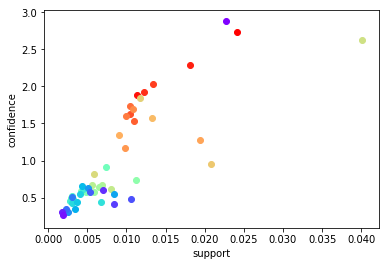

In [14]:
# Plot relationship between support and confidence

colors = cm.rainbow(np.linspace(0, 1, len(support)))
for i in range(len(support)):
    plt.scatter(support[i], confidence[i], color=colors[-i])
plt.xlabel('support')
plt.ylabel('confidence') 
plt.show() # red dots indicates the highest lift value